In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns
import requests
import datetime as dt
from datetime import datetime, timedelta
import zipfile
import io
import re
import os
import csv

# Para machine learning
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from math import sqrt
import joblib
import pickle


#
import statsmodels
from statsmodels.tsa.stattools import adfuller, kpss    #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_to_json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

!pip install tabulate
!pip install chardet
#!pip install streamlit
#!pip install pandas openpyxl
#!pip install seaborn

#import streamlit as st

import matplotlib.pyplot as plt
import statsmodels.api as sm
from tabulate import tabulate
import chardet

# SELECIONANDO PRECISAO DECIMAL NO PANDAS EM ZERO DECIMAIS
pd.set_option("display.precision", 2)

In [ ]:
def get_file_type(file_path):
  """Returns the file type of a file.
  """
  extension = os.path.splitext(file_path)[1].lower()
  if extension == '.csv':
    return 'csv'
  elif extension == '.txt':
    return 'txt'
  elif extension == '.zip':
    return 'zip'
  else:
    return 'unknown'

def filter_columns(df, filters: list): # adiciono no array o padrão que existe nas colunas e que não quero que tenha na saída final
    selected_columns = [True] * len(df.columns)  # Inicializa todas as colunas como True
    for index, column in enumerate(df.columns):
        if any(filter in column for filter in filters): selected_columns[index] = False
    return df[df.columns[selected_columns]]

def compare_columns_by_pattern(df, pattern, years):
  """
  Calculates the difference between columns with a common pattern across years.

  Args:
    df: The DataFrame to work with.
    pattern: The common pattern in column names (e.g., "IPS_").
    years: A list of years to compare (e.g., [2020, 2021, 2022]).

  Returns:
    The DataFrame with new columns containing the differences.
  """

  for i in range(len(years) - 1):
    year1 = years[i]
    year2 = years[i + 1]
    col1 = f"{pattern}{year1}_NUM"
    col2 = f"{pattern}{year2}_NUM"

    # Check if both columns exist in the DataFrame
    if col1 in df.columns and col2 in df.columns:
      # Calculate the difference and create a new column
      df[f"{pattern}{year1}_{year2}_DIFF"] = df[col2] - df[col1]
    else:
      print(f"Warning: Columns {col1} or {col2} not found in DataFrame.")

  return df


def cleaning_dataset(df):
  _df = df.dropna(subset=df.columns.difference(['NOME']), how='all') # executa o dropna para todas as colunas sem visualizar a coluna NOME
  _df = _df[~_df.isna().all(axis=1)] # remove linhas com apenas NaN, se tiver algum dado na linha não remove
  return _df

def plot_exact_counter(size, x, y, df) -> None:
  import matplotlib.pyplot as plt
  import seaborn as sns
  import pandas as pd

  plt.figure(figsize=size)
  barplot = plt.bar(y.index, y.values)
  plt.xlabel(x)
  plt.ylabel('Count')

  for index, value in enumerate(y.values):
        plt.text(index, value, round(value, 2), color='black', ha="center")

  plt.show()


def count_in_interval(x):
  return pd.cut(x, bins=[i[0] for i in intervals] + [intervals[-1][1]], labels=[f'{i[0]}-{i[1]}' for i in intervals], include_lowest=True).value_counts()


def find_rows_with_value(df, value):
    rows = df[df.isin([value]).any(axis=1)].index.tolist()
    column = df[df.isin([value]).any(axis=1)].apply(lambda row: row[row == value].index.tolist(), axis=1).tolist()
    # Use apply to find the column name for each row where the value exists
    list_found = list(zip(rows, column))
    return list_found


def replace_pattern_in_dataframe(df, pattern, replacement):
  """Replaces a pattern in all columns of a DataFrame.

  Args:
      df: The Pandas DataFrame.
      pattern: The pattern to search for (string or regular expression).
      replacement: The value to replace the pattern with.

  Returns:
      A new DataFrame with the pattern replaced.
  """

  df.replace(pattern, replacement, regex=True, inplace=True)


def find_rows_with_pattern(df, value):
    # Stack the DataFrame
    stacked = df.stack()

    # Find matches
    matches = stacked[stacked.apply(lambda x: bool(re.search(pattern, str(x))))]

    # Get the rows that have matches
    matching_rows = df.iloc[matches.index.get_level_values(0).unique()]

    return matching_rows


def delete_rows_with_value_and_column(df, column, value):
    indices = df[df[column].isin([value])].index
    # Remove rows
    df = df.drop(indices, inplace=True)

def delete_rows_with_index(df, index):
    df = df.drop(index, inplace=True)


def cross_two_columns_by_intervals(df_input, column_name1, column_name2, intervals):

  # Como funciona o intervalo?
  #intervals = [3.03, 3.67, 4.31, 4.96, 5.60, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00]

  bins = intervals

  df_temp = df_input.copy()

  df_temp[column_name1] = df_temp[column_name1].astype(str).str.replace('nan', '', regex=False)

  df_temp[column_name2] = pd.to_numeric(df_temp[column_name2], errors='coerce')
  df_temp[column_name2] = df_temp[column_name2].fillna(0)
  df_temp[column_name2] = df_temp[column_name2].astype(float)

  # Generate labels based on the intervals
  labels = [f'{intervals[i]}-{intervals[i+1]}' for i in range(len(intervals) - 1)]

  # Define a function to apply to each group
  def count_intervals(x):
    return pd.cut(x, bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()

  counts = df_temp.groupby(column_name1)[column_name2].apply(count_intervals).unstack(fill_value=0)

  print(counts)

  return counts


def count_by_intervals(df_input, intervals):
  #intervals = [3.03, 3.67, 4.31, 4.96, 5.60, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00]

# Use the intervals list directly for bins
  bins = intervals

  df_temp = df_input.copy()
  df_temp = pd.to_numeric(df_temp, errors='coerce')
  df_temp = df_temp.fillna(0)
  df_temp = df_temp.astype(float)

  # Generate labels based on the intervals
  labels = [f'{intervals[i]}-{intervals[i+1]}' for i in range(len(intervals) - 1)]

  # Assuming 'x' is a Pandas Series or DataFrame column
  #pd.cut(df_input, bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()
  return pd.cut(df_input, bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()


def analyse_corr(df):
  df = df.apply(pd.to_numeric, errors='coerce')
  corr_matrix = df.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
  plt.show()


def count_stones_per_year(df):
  """
  Calculates the amount of each stone per year based on the FASE_{year}_INT column
  and returns a tabulated result with absolute numbers and percentages.

  Args:
    df: Pandas DataFrame containing the data.

  Returns:
    A pandas DataFrame with the tabulated results.
  """

  all_counts = []
  for year in range(2020, 2024):
    pedra_col = f'PEDRA_{year}_STR'
    fase_col = f'FASE_{year}_STR'
    if pedra_col in df.columns and fase_col in df.columns:
      filtered_df = df[df[pedra_col] != 'None']
      counts = filtered_df.groupby(pedra_col)[fase_col].value_counts().unstack(fill_value=0)
      total = counts.sum(axis=0)
#      percentage = (counts / total * 100).round(2)
      counts['Total'] = counts.sum(axis=1)
#      percentage['Total'] = percentage.sum(axis=1)
#      all_counts.append(pd.concat([counts, percentage], keys=['Count', 'Percentage'], axis=1))
      all_counts.append(pd.concat([counts], keys=['Count'], axis=1))

  result = pd.concat(all_counts, keys=range(2020, 2024), axis=1)
  return result

# Example usage:
#stone_counts_by_year = count_stones_per_year(df)
#print(stone_counts_by_year)

In [ ]:
# Pattern to search for
#find_rows_with_pattern(df, 'Nível')

In [ ]:
import pandas as pd

def label_success(df, column_name, pattern):
  """
  Labels success based on a pattern in a specified column.

  Args:
    df: Pandas DataFrame.
    column_name: Name of the column to search for the pattern.
    pattern: The pattern to search for (can be a string, number, or regular expression).

  Returns:
    DataFrame with a new 'Success' column (1 for success, 0 otherwise).
  """

  df['Success'] = 0

  if isinstance(pattern, str):
    # For string patterns, use str.contains
    df.loc[df[column_name].str.contains(pattern, na=False), 'Success'] = 1
  else:
    # For other data types, use direct comparison
    df.loc[df[column_name] == pattern, 'Success'] = 1

  return df

In [ ]:
## Aquisição de arquivo de base de dados do Google Drive do Datathon

## url para arquivo csv 'PEDE_PASSOS_DATASET_FIAP.csv'
#url = 'https://drive.google.com/file/d/1io7twhaAET_idhoyREhyaOCuU3gGAgIa/view?usp=sharing'

## url para arquivo csv 'PEDE_PASSOS_DATASET_FIAP.csv' sem linha com problema

# 2024-09-20 old
#url = 'https://drive.google.com/file/d/1A4ce0x_i7cndiLcs6z1rkOf1855TkqAE/view?usp=sharing'

# 2024-09-20 new
#url = 'https://drive.google.com/file/d/1vtBjB-enW36CpU6KUg9MXAsNCy8fSnla/view?usp=sharing'
url = 'https://drive.google.com/file/d/1lp2aGCBwabHiIFRzHV4TggdKXsJIFRxq/view?usp=sharing'
#url = 'https://drive.google.com/file/d/12Uxn5YOmRUlKy8qjfC_80o7WYmz9mOcT/view?usp=sharing'

## url para arquivo zip 'Base de dados - Passo Mágicos.zip'
## url = 'https://drive.google.com/file/d/1CqQLozHeilyxzvGvvMi29Dbzl3t66wik/view?usp=sharing'

file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
file_url = dwn_url

r = requests.get(file_url)

if 'Content-Disposition' in r.headers:
    # Extract filename from Content-Disposition header
    match = re.search('filename="([^"]+)"', r.headers['Content-Disposition'])
    if match:
        filename = match.group(1)
    else:
        filename = url.split('/')[-1]
else:
    # Extract filename from URL
    filename = url.split('/')[-1]

print(file_url, filename)
filetype = get_file_type(filename)

result = chardet.detect(r.content)
print(result)

if filetype == 'csv':
    df = pd.read_csv(io.BytesIO(r.content), sep=';', encoding=result.get('encoding'), engine='python')
elif filetype == 'txt':
    df = pd.read_csv(io.BytesIO(r.content), sep='\t', encoding=result.get('encoding'), engine='python')
elif filetype == 'zip':
    z = zipfile.ZipFile(io.BytesIO(r.content))
    zipped_filelist = z.namelist()
    print(zipped_filelist)



    ## Análise do conteudo do arquivo zipado
    ## Se precisar gerar dataframe para certos arquivos dentro do zip, os loops abaixo ajudam

    pattern = re.compile(r'.+merged.+.csv$')
    lista_filtrada_merged = [x for x in zipped_filelist if pattern.match(x)]

    for file in lista_filtrada_merged:
        new_dataframe = "df_" + f"{file.split('/')[-3]}".lower()
        print(new_dataframe)


    pattern = re.compile(r'.+Outras.+.csv$')
    lista_filtrada_outros = [x for x in zipped_filelist if pattern.match(x)]

    #print(lista_filtrada_outros)
    for file in lista_filtrada_outros:
        new_dataframe = "df_" + f"{file.split('/')[-1].split('.')[-2]}".lower()
        print(new_dataframe)


print(f"Filetype {filetype}")


https://drive.google.com/uc?export=download&id=1lp2aGCBwabHiIFRzHV4TggdKXsJIFRxq PEDE_PASSOS_DATASET_FIAP_v8.csv
{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}
Filetype csv


In [ ]:
## Aquisição de arquivo zip do Google Drive do Datathon


#file_id = url.split('/')[-2]
#dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
#zip_file_url = dwn_url

#r = requests.get(zip_file_url)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#zipped_filelist = z.namelist()
#print(zipped_filelist)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Data columns (total 77 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   INDEX                              1346 non-null   int64  
 1   NOME_STR                           1346 non-null   object 
 2   INSTITUICAO_ENSINO_ALUNO_2020_STR  725 non-null    object 
 3   IDADE_ALUNO_2020_INT               725 non-null    float64
 4   ANOS_PM_2020_INT                   725 non-null    float64
 5   SINALIZADOR_INGRESSANTE_2020_STR   725 non-null    object 
 6   ANO_INGRESSO_2020_DATE             725 non-null    float64
 7   FASE_TURMA_2020_STR                725 non-null    object 
 8   FASE_2020_STR                      725 non-null    object 
 9   TURMA_2020_STR                     725 non-null    object 
 10  PONTO_VIRADA_2020_STR              699 non-null    object 
 11  INDE_2020_NUM                      725 non-null    float

In [ ]:
replace_pattern_in_dataframe(df, 'Nível', 'Fase')

In [ ]:
replace_pattern_in_dataframe(df, 'º', 'o')

In [ ]:
delete_rows_with_value_and_column(df, 'NOME_STR', 'ALUNO-1259')

In [ ]:
delete_rows_with_value_and_column(df, 'NOME_STR', 'ALUNO-374')

In [ ]:
delete_rows_with_value_and_column(df, 'NOME_STR', 'ALUNO-1196')

In [ ]:

# Define a function for conditional extraction
def extract_value(text):
  if isinstance(text, str):
    if 'ALFA' in text:
      return 'ALFA'
    elif 'null' in text.lower():
      return None
    elif text == '0':  # Check if the string is literally '0'
      return '0'     # Return '0' if it is
    else:
      # Use re.search to extract digits from the string
      match = re.search('(\d+)', text)
      if match:
        return match.group(1)
      else:
        return None
  else:
    return None


# Apply the function to the 'NIVEL_IDEAL_2021_STR' column
df['NIVEL_IDEAL_2020_CLEAN'] = df['FASE_2020_STR']
df['NIVEL_IDEAL_2021_CLEAN'] = df['NIVEL_IDEAL_2021_STR'].apply(extract_value)
df['NIVEL_IDEAL_2022_CLEAN'] = df['NIVEL_IDEAL_2022_STR'].apply(extract_value)


In [ ]:
for col in [col for col in df.columns if col.endswith('_INT')]:
    # Convert to float first, handling non-finite values with 'coerce'
    #df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].astype(str).str.replace('.0', '', regex=False).replace('nan', '')
    df[col] = pd.to_numeric(df[col], errors='coerce') # convert the column to numeric type, coerce will replace invalid parsing as NaN
    # Now convert to integer, filling NaNs with a suitable value (e.g., -1)
    df[col] = df[col].fillna(0).astype(float)
    df[col] = df[col].fillna('')


In [ ]:

for col in [col for col in df.columns if col.endswith('_NUM')]:
    # Convert column to string type
    df[col] = df[col].astype(str)
    # Replace '#NULO!' and 'nan' with empty strings
    df[col] = df[col].str.replace('#NULO!', '').str.replace('nan', '')
    # Convert column to float type, non-numeric values will be converted to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce') # use pd.to_numeric with errors='coerce' to handle invalid parsing
    # Fill NaN values with 0 and convert to float type
    df[col] = df[col].fillna(0).astype(float)
    df[col] = df[col].fillna('')



In [ ]:
for col in [col for col in df.columns if col.endswith('_DATE')]:
    # Convert the column to string type
    df[col] = df[col].astype(str)
    # Replace 'nan' with empty string
    df[col] = df[col].str.replace('nan', '')
    # Convert the column to numeric type, coerce will replace invalid parsing as NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Convert to datetime objects with year format, handling errors
    df[col] = pd.to_datetime(df[col], format='%Y', errors='coerce').dt.year
    # Fill NaN with 0 and convert to int
    df[col] = df[col].fillna(0).astype(int)
    # Remove '.0' from the year values
    df[col] = df[col].astype(str).str.replace('.0', '', regex=False)
    df[col] = df[col].fillna('')

In [ ]:
for col in [col for col in df.columns if col.endswith('_STR')]:
    df[col] = df[col].str.replace('#NULO!', '').str.replace('nan', '')
    df[col] = df[col].fillna('')


In [ ]:
for col in [col for col in df.columns if col.startswith('IDADE')]:
    # Convert the column to string type
    df[col] = df[col].astype(str)
    # Replace 'nan' with empty string
    df[col] = df[col].str.replace('nan', '')
    # Convert the column to float type, coerce will replace invalid parsing as NaN
    df[col] = pd.to_numeric(df[col], errors='coerce') # Use errors='coerce' to handle invalid parsing
    # Convert the column to integer type
    df[col] = df[col].fillna(0).astype('int') # Fill NaN with 0 and convert to int
    df[col] = df[col].fillna('')


In [ ]:
df = df.round(4)
pd.set_option('display.max_columns', None)
df.head(25)

,INDEX,NOME_STR,INSTITUICAO_ENSINO_ALUNO_2020_STR,IDADE_ALUNO_2020_INT,ANOS_PM_2020_INT,SINALIZADOR_INGRESSANTE_2020_STR,ANO_INGRESSO_2020_DATE,FASE_TURMA_2020_STR,FASE_2020_STR,TURMA_2020_STR,PONTO_VIRADA_2020_STR,INDE_2020_NUM,INDE_CONCEITO_2020_STR,PEDRA_2020_STR,DESTAQUE_IEG_2020_STR,DESTAQUE_IDA_2020_STR,DESTAQUE_IPV_2020_STR,IAA_2020_NUM,IEG_2020_NUM,IPS_2020_NUM,IDA_2020_NUM,IPP_2020_NUM,IPV_2020_NUM,IAN_2020_NUM,FASE_2021_STR,TURMA_2021_STR,INSTITUICAO_ENSINO_ALUNO_2021_STR,SINALIZADOR_INGRESSANTE_2021_STR,ANO_INGRESSO_2021_DATE,PEDRA_2021_STR,INDE_2021_NUM,IAA_2021_NUM,IEG_2021_NUM,IPS_2021_NUM,IDA_2021_NUM,IPP_2021_NUM,REC_AVA_1_2021_STR,REC_AVA_2_2021_STR,REC_AVA_3_2021_STR,REC_AVA_4_2021_STR,PONTO_VIRADA_2021_STR,IPV_2021_NUM,IAN_2021_NUM,NIVEL_IDEAL_2021_STR,DEFASAGEM_2021_NUM,FASE_2022_STR,TURMA_2022_STR,INSTITUICAO_ENSINO_ALUNO_2022_STR,SINALIZADOR_INGRESSANTE_2022_STR,ANO_INGRESSO_2022_DATE,BOLSISTA_2022_STR,INDE_2022_NUM,CG_2022_INT,CF_2022_INT,CT_2022_INT,PEDRA_2022_STR,DESTAQUE_IEG_2022_STR,DESTAQUE_IDA_2022_STR,DESTAQUE_IPV_2022_STR,IAA_2022_NUM,IEG_2022_NUM,IPS_2022_NUM,IDA_2022_NUM,NOTA_PORT_2022_NUM,NOTA_MAT_2022_NUM,NOTA_ING_2022_NUM,QTD_AVAL_2022_INT,IPP_2022_NUM,REC_AVA_1_2022_STR,REC_AVA_2_2022_STR,REC_AVA_3_2022_STR,REC_AVA_4_2022_STR,INDICADO_BOLSA_2022_STR,PONTO_VIRADA_2022_STR,IPV_2022_NUM,IAN_2022_NUM,NIVEL_IDEAL_2022_STR,NIVEL_IDEAL_2020_CLEAN,NIVEL_IDEAL_2021_CLEAN,NIVEL_IDEAL_2022_CLEAN
0,1,ALUNO-1,Escola Pública,11,2.0,Veterano,2018,2H,2,H,Não,8.0,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.50,8.7,7.50,7.00,5.94,7.75,10.0,2,G,Rede Decisão,Veterano,2018,Ametista,7.32,7.5,6.3,6.9,8.8,7.7,Promovido de Fase,Promovido de Fase,Mantido na Fase atual,Não avaliado,Não,8.1,5.0,Fase 3 (7o e 8o ano),-1.0,,,,,0,,0.00,0.0,0.0,0.0,,,,,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,,,,,,,0.00,0.0,,2,3,None
1,2,ALUNO-2,,0,0.0,,0,,,,,0.0,,,,,,0.00,0.0,0.00,0.00,0.00,0.00,0.0,,,,,0,,0.00,0.0,0.0,0.0,0.0,0.0,,,,,,0.0,0.0,,0.0,ALFA,K,Escola Pública,Ingressante,2022,Não,7.68,245.0,66.0,6.0,Ametista,Destaque: A sua boa entrega das lições de casa.,Destaque: As suas boas notas na Passos Mágicos.,Destaque: A sua boa integração aos Princípios ...,10.00,7.58,7.50,8.82,8.20,9.43,0.00,2.0,5.62,Mantido na Fase + Bolsa,Mantido na Fase atual,,,Sim,Não,7.92,5.0,Fase 2 (5o e 6o ano),NaN,None,2
2,3,ALUNO-3,Escola Pública,12,2.0,Veterano,2018,3H,3,H,Não,8.0,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.92,8.9,7.50,5.50,8.12,8.11,10.0,3,F,Escola Pública,Veterano,2018,Ametista,7.02,7.1,6.9,6.3,5.6,7.3,Promovido de Fase,Promovido de Fase,Mantido na Fase atual,Não avaliado,Não,7.2,10.0,Fase 3 (7o e 8o ano),0.0,,,,,0,,0.00,0.0,0.0,0.0,,,,,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,,,,,,,0.00,0.0,,3,3,None
3,4,ALUNO-4,Escola Pública,10,2.0,Veterano,2018,1D,1,D,Não,5.0,D,Quartzo,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,8.00,4.1,6.88,0.00,7.19,7.75,5.0,,,,,0,,0.00,0.0,0.0,0.0,0.0,0.0,,,,,,0.0,0.0,,0.0,2,J,Escola Pública,Ingressante,2022,Não,7.12,451.0,69.0,3.0,Ametista,Destaque: A sua boa entrega das lições de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Destaque: A sua boa integração aos Princípios ...,10.00,8.07,7.50,5.08,5.00,5.17,0.00,3.0,6.25,Promovido de Fase,Mantido na Fase atual,Promovido de Fase,,Não,Não,8.06,5.0,Fase 3 (7o e 8o ano),1,None,3
4,5,ALUNO-5,Escola Pública,10,1.0,Veterano,2019,2M,2,M,Não,8.0,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Seu destaque em 2020: As suas boas notas na Pa...,Seu destaque em 2020: A sua boa integração aos...,7.50,8.0,7.50,7.50,8.44,8.17,10.0,2,L,Escola Pública,Veterano,2019,Ametista,7.40,7.4,7.5,7.5,5.4,8.5,Promovido de Fase,

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344 entries, 0 to 1345
Data columns (total 80 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   INDEX                              1344 non-null   int64  
 1   NOME_STR                           1344 non-null   object 
 2   INSTITUICAO_ENSINO_ALUNO_2020_STR  1344 non-null   object 
 3   IDADE_ALUNO_2020_INT               1344 non-null   int64  
 4   ANOS_PM_2020_INT                   1344 non-null   float64
 5   SINALIZADOR_INGRESSANTE_2020_STR   1344 non-null   object 
 6   ANO_INGRESSO_2020_DATE             1344 non-null   object 
 7   FASE_TURMA_2020_STR                1344 non-null   object 
 8   FASE_2020_STR                      1344 non-null   object 
 9   TURMA_2020_STR                     1344 non-null   object 
 10  PONTO_VIRADA_2020_STR              1344 non-null   object 
 11  INDE_2020_NUM                      1344 non-null   float64
 1

In [ ]:
## Criação de dataframes por ano e incluir nome

# List of patterns
patterns = [r'2020', r'NOME']

# Combine patterns into a single regular expression
combined_pattern = '|'.join(patterns)

# Filter columns based on the combined pattern
df_2020 = df.filter(regex=combined_pattern)


# List of patterns
patterns = [r'2021', r'NOME']

# Combine patterns into a single regular expression
combined_pattern = '|'.join(patterns)

# Filter columns based on the combined pattern
df_2021 = df.filter(regex=combined_pattern)


# List of patterns
patterns = [r'2022', r'NOME']

# Combine patterns into a single regular expression
combined_pattern = '|'.join(patterns)

# Filter columns based on the combined pattern
df_2022 = df.filter(regex=combined_pattern)


In [ ]:
# Check if the DataFrame is empty after filtering
# Check if the DataFrame is empty after filtering
#if df[df.isin([10.00]).any(axis=1)].empty:
#    # Access the first row if the DataFrame is not empty
#    print("No rows found with a value equal to 10.00")
#else:
#    first_row = df[df.isin([10.00]).any(axis=1)]
#    print(first_row)

In [ ]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344 entries, 0 to 1345
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   NOME_STR                           1344 non-null   object 
 1   FASE_2022_STR                      1344 non-null   object 
 2   TURMA_2022_STR                     1344 non-null   object 
 3   INSTITUICAO_ENSINO_ALUNO_2022_STR  1344 non-null   object 
 4   SINALIZADOR_INGRESSANTE_2022_STR   1344 non-null   object 
 5   ANO_INGRESSO_2022_DATE             1344 non-null   object 
 6   BOLSISTA_2022_STR                  1344 non-null   object 
 7   INDE_2022_NUM                      1344 non-null   float64
 8   CG_2022_INT                        1344 non-null   float64
 9   CF_2022_INT                        1344 non-null   float64
 10  CT_2022_INT                        1344 non-null   float64
 11  PEDRA_2022_STR                     1344 non-null   object 
 1

In [ ]:

# Convert 'NIVEL_IDEAL_2022_STR' to string type
df['NIVEL_IDEAL_2022_STR'] = df['NIVEL_IDEAL_2022_STR'].astype(str)

pattern = r'.*'  # Use a regex pattern to match "Fase 8" followed by any characters

# Normalize the strings to handle potential encoding issues
#df['NIVEL_IDEAL_2022_STR'] = df['NIVEL_IDEAL_2022_STR'].apply(lambda x: x.encode('latin1').decode('utf-8'))

# Find matching rows using a list comprehension
matching_rows = [(x, y) for x, y in zip(df['NIVEL_IDEAL_2022_STR'], df['INDE_2022_NUM']) if re.match(pattern, x)]

# Print the matching values
print(f"Values in 'NIVEL_IDEAL_2022_STR' and 'INDE_2022_NUM' where 'NIVEL_IDEAL_2022_STR' contains '{pattern}':")
for row in matching_rows:
    print(row)

counts = df.groupby('NIVEL_IDEAL_2022_STR')['INDE_2022_NUM'].count()


print(f"Count of values in 'INDE_2022_NUM' where 'NIVEL_IDEAL_2022_STR' contains '{pattern}': {counts}")

Values in 'NIVEL_IDEAL_2022_STR' and 'INDE_2022_NUM' where 'NIVEL_IDEAL_2022_STR' contains '.*':
('', 0.0)
('Fase 2 (5o e 6o ano)', 7.676)
('', 0.0)
('Fase 3 (7o e 8o ano)', 7.117)
('Fase 3 (7o e 8o ano)', 7.232)
('Fase 2 (5o e 6o ano)', 7.742)
('Fase 2 (5o e 6o ano)', 7.407)
('Fase 6 (2o EM)', 7.29)
('ALFA  (2o e 3o ano)', 5.666)
('', 0.0)
('Fase 2 (5o e 6o ano)', 8.465)
('', 0.0)
('', 0.0)
('', 0.0)
('', 0.0)
('Fase 2 (5o e 6o ano)', 6.996)
('Fase 3 (7o e 8o ano)', 6.723)
('Fase 6 (2o EM)', 5.846)
('Fase 3 (7o e 8o ano)', 7.843)
('ALFA  (2o e 3o ano)', 8.616)
('Fase 6 (2o EM)', 5.652)
('ALFA  (2o e 3o ano)', 8.098)
('Fase 2 (5o e 6o ano)', 7.783)
('Fase 2 (5o e 6o ano)', 8.27)
('ALFA  (2o e 3o ano)', 7.952)
('Fase 1 (4o ano)', 7.738)
('Fase 4 (9o ano)', 6.35)
('', 0.0)
('Fase 6 (2o EM)', 4.936)
('Fase 1 (4o ano)', 8.084)
('ALFA  (2o e 3o ano)', 7.263)
('Fase 8 (Universitários)', 6.793)
('', 0.0)
('Fase 4 (9o ano)', 6.667)
('', 0.0)
('Fase 6 (2o EM)', 6.854)
('Fase 3 (7o e 8o ano)', 7

In [ ]:
df['NIVEL_IDEAL_2020_CLEAN'].value_counts()

,count
NIVEL_IDEAL_2020_CLEAN,
1,172
2,155
3,122
ALFA,80
4,55
5,54
7,33
6,30
8,24


In [ ]:
def count_by_intervals(df_input, intervals):
  #intervals = [3.03, 3.67, 4.31, 4.96, 5.60, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00]

# Use the intervals list directly for bins
  bins = intervals

  df_temp = df_input.copy()
  df_temp = pd.to_numeric(df_temp, errors='coerce')
  df_temp = df_temp.fillna(0)
  df_temp = df_temp.astype(float)

  # Generate labels based on the intervals
  labels = [f'{intervals[i]}-{intervals[i+1]}' for i in range(len(intervals) - 1)]

  # Assuming 'x' is a Pandas Series or DataFrame column
  #pd.cut(df_input, bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()
  return pd.cut(df_input, bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()

In [ ]:
count_by_intervals(df['IAN_2020_NUM'], intervals=[1.00, 3.50, 4.30, 4.70, 5.00, 5.30, 5.60, 5.90, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00])
#count_by_intervals(df['IAN_2021_NUM'], intervals=[1.00, 3.50, 4.30, 4.70, 5.00, 5.30, 5.60, 5.90, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00])
#count_by_intervals(df['IAN_2022_NUM'], intervals=[1.00, 3.50, 4.30, 4.70, 5.00, 5.30, 5.60, 5.90, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00])

,count
IAN_2020_NUM,
1.0-3.5,11
3.5-4.3,0
4.3-4.7,0
4.7-5.0,356
5.0-5.3,0
5.3-5.6,0
5.6-5.9,0
5.9-6.24,0
6.24-6.88,0


In [ ]:
def cross_two_columns_by_intervals(df_input, column_name1, column_name2, intervals):
  #intervals = [3.03, 3.67, 4.31, 4.96, 5.60, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00]

# Use the intervals list directly for bins
  bins = intervals

  df_temp = df_input.copy()

  df_temp[column_name1] = df_temp[column_name1].astype(str).str.replace('nan', '', regex=False)

  df_temp[column_name2] = pd.to_numeric(df_temp[column_name2], errors='coerce')
  df_temp[column_name2] = df_temp[column_name2].fillna(0)
  df_temp[column_name2] = df_temp[column_name2].astype(float)

  # Generate labels based on the intervals
  labels = [f'{intervals[i]}-{intervals[i+1]}' for i in range(len(intervals) - 1)]

  # Define a function to apply to each group
  def count_intervals(x):
    return pd.cut(x, bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()

  counts = df_temp.groupby(column_name1)[column_name2].apply(count_intervals).unstack(fill_value=0)

  print(counts)

  return counts

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344 entries, 0 to 1345
Data columns (total 80 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   INDEX                              1344 non-null   int64  
 1   NOME_STR                           1344 non-null   object 
 2   INSTITUICAO_ENSINO_ALUNO_2020_STR  1344 non-null   object 
 3   IDADE_ALUNO_2020_INT               1344 non-null   int64  
 4   ANOS_PM_2020_INT                   1344 non-null   float64
 5   SINALIZADOR_INGRESSANTE_2020_STR   1344 non-null   object 
 6   ANO_INGRESSO_2020_DATE             1344 non-null   object 
 7   FASE_TURMA_2020_STR                1344 non-null   object 
 8   FASE_2020_STR                      1344 non-null   object 
 9   TURMA_2020_STR                     1344 non-null   object 
 10  PONTO_VIRADA_2020_STR              1344 non-null   object 
 11  INDE_2020_NUM                      1344 non-null   float64
 1

In [ ]:
cross_two_columns_by_intervals(df, 'PEDRA_2020_STR', 'IPV_2020_NUM', [1.03, 3.67, 4.31, 4.96, 5.60, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00])

                1.03-3.67  3.67-4.31  4.31-4.96  4.96-5.6  5.6-6.24  \
PEDRA_2020_STR                                                        
                        0          0          0         0         0   
Ametista                0          0          3         3         6   
Quartzo                 1          3          9        13        17   
Topázio                 0          0          0         0         1   
Ágata                   3          2          2         4        12   

                6.24-6.88  6.88-7.52  7.52-8.16  8.16-8.8  8.8-9.44  9.44-10.0  
PEDRA_2020_STR                                                                  
                        0          0          0         0         0          0  
Ametista               15         82        115        56        42          4  
Quartzo                28         32         20         1         0          0  
Topázio                 5         12         23        11        17         17  
Ágata           

,1.03-3.67,3.67-4.31,4.31-4.96,4.96-5.6,5.6-6.24,6.24-6.88,6.88-7.52,7.52-8.16,8.16-8.8,8.8-9.44,9.44-10.0
PEDRA_2020_STR,,,,,,,,,,,
,0,0,0,0,0,0,0,0,0,0,0
Ametista,0,0,3,3,6,15,82,115,56,42,4
Quartzo,1,3,9,13,17,28,32,20,1,0,0
Topázio,0,0,0,0,1,5,12,23,11,17,17
Ágata,3,2,2,4,12,19,46,64,11,0,0


In [ ]:
cross_two_columns_by_intervals(df, 'PEDRA_2021_STR', 'IPV_2021_NUM', [1.03, 3.67, 4.31, 4.96, 5.60, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00])

                1.03-3.67  3.67-4.31  4.31-4.96  4.96-5.6  5.6-6.24  \
PEDRA_2021_STR                                                        
                        0          0          0         0         0   
Ametista                0          0          0         0         2   
Quartzo                15         19         16        20        16   
Topázio                 0          0          0         0         0   
Ágata                   0          2          6        20        30   

                6.24-6.88  6.88-7.52  7.52-8.16  8.16-8.8  8.8-9.44  9.44-10.0  
PEDRA_2021_STR                                                                  
                        0          0          0         0         0          0  
Ametista               17         53         76        99        40          7  
Quartzo                15          5          3         1         0          0  
Topázio                 0          0          3        19        29         49  
Ágata           

,1.03-3.67,3.67-4.31,4.31-4.96,4.96-5.6,5.6-6.24,6.24-6.88,6.88-7.52,7.52-8.16,8.16-8.8,8.8-9.44,9.44-10.0
PEDRA_2021_STR,,,,,,,,,,,
,0,0,0,0,0,0,0,0,0,0,0
Ametista,0,0,0,0,2,17,53,76,99,40,7
Quartzo,15,19,16,20,16,15,5,3,1,0,0
Topázio,0,0,0,0,0,0,0,3,19,29,49
Ágata,0,2,6,20,30,34,50,24,12,0,0


In [ ]:
cross_two_columns_by_intervals(df, 'PEDRA_2022_STR', 'IPV_2022_NUM', [1.03, 3.67, 4.31, 4.96, 5.60, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00])

                1.03-3.67  3.67-4.31  4.31-4.96  4.96-5.6  5.6-6.24  \
PEDRA_2022_STR                                                        
                        0          0          0         0         0   
Ametista                0          0          0         2         6   
Quartzo                 2         12         19        17        36   
Topázio                 0          0          0         0         0   
Ágata                   0          0          0        13        38   

                6.24-6.88  6.88-7.52  7.52-8.16  8.16-8.8  8.8-9.44  9.44-10.0  
PEDRA_2022_STR                                                                  
                        0          0          0         0         0          0  
Ametista               28        126        116        56        12          2  
Quartzo                23         22          3         0         0          0  
Topázio                 0         19         23        49        27         12  
Ágata           

,1.03-3.67,3.67-4.31,4.31-4.96,4.96-5.6,5.6-6.24,6.24-6.88,6.88-7.52,7.52-8.16,8.16-8.8,8.8-9.44,9.44-10.0
PEDRA_2022_STR,,,,,,,,,,,
,0,0,0,0,0,0,0,0,0,0,0
Ametista,0,0,0,2,6,28,126,116,56,12,2
Quartzo,2,12,19,17,36,23,22,3,0,0,0
Topázio,0,0,0,0,0,0,19,23,49,27,12
Ágata,0,0,0,13,38,62,97,35,5,0,0


In [ ]:
# Define the intervals
intervals = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9),(9, 10)]

# Group by 'NIVEL_IDEAL_2022_STR' and count INDE by intervals
def count_in_interval(x):
  return pd.cut(x, bins=[i[0] for i in intervals] + [intervals[-1][1]], labels=[f'{i[0]}-{i[1]}' for i in intervals], include_lowest=True).value_counts()

for col in [col for col in df.columns if col.endswith('_NUM')]:
  counts = df.groupby('NIVEL_IDEAL_2022_STR')['INDE_2022_NUM'].apply(count_in_interval).unstack(fill_value=0)

# Print the counts for each group and interval
print(counts)

                         0-1  1-2  2-3  3-4  4-5  5-6  6-7  7-8  8-9  9-10
NIVEL_IDEAL_2022_STR                                                      
                         482    0    0    0    0    0    0    0    0     0
ALFA  (2o e 3o ano)        0    0    0    0    1    1    8   34   27     0
Fase 1 (4o ano)            0    0    0    1    0    2   18   50   25     0
Fase 2 (5o e 6o ano)       0    0    0    0    3   13   59  111   32     0
Fase 3 (7o e 8o ano)       0    0    0    1    6   24   67   78   30     1
Fase 4 (9o ano)            0    0    0    0    6   19   31   19   10     0
Fase 5 (1o EM)             0    0    0    1    6    6   26   16    6     2
Fase 6 (2o EM)             0    0    0    2    5   13   15   15    2     0
Fase 7 (3o EM)             0    0    0    2    6    7   12   16    5     0
Fase 8 (Universitários)    0    0    0    1    2    6    6    5    2     0


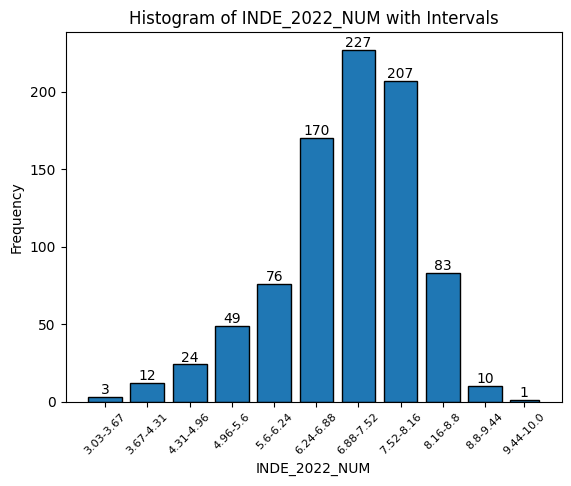

In [ ]:

# Define the intervals
intervals = [3.03, 3.67, 4.31, 4.96, 5.60, 6.24, 6.88, 7.52, 8.16, 8.80, 9.44, 10.00]

# Create the histogram
counts, edges, _ = plt.hist(df['INDE_2022_NUM'], bins=intervals, edgecolor='black', rwidth=0.8)

#plt.hist(df['INDE_2022_NUM'], bins=intervals, edgecolor='black')

# Customize the plot
plt.xlabel('INDE_2022_NUM')
plt.ylabel('Frequency')
plt.title('Histogram of INDE_2022_NUM with Intervals')

# Set x-axis tick labels with interval ranges
interval_labels = [f'{edges[i]}-{edges[i+1]}' for i in range(len(edges)-1)]
plt.xticks([(edges[i] + edges[i+1])/2 for i in range(len(edges)-1)], interval_labels, rotation=45, fontsize = 8) # Center the label

for i in range(len(counts)):
    plt.text(edges[i] + ((edges[i+1] - edges[i])/2), counts[i], str(int(counts[i])), ha='center', va='bottom')

# Show the plot
plt.show()

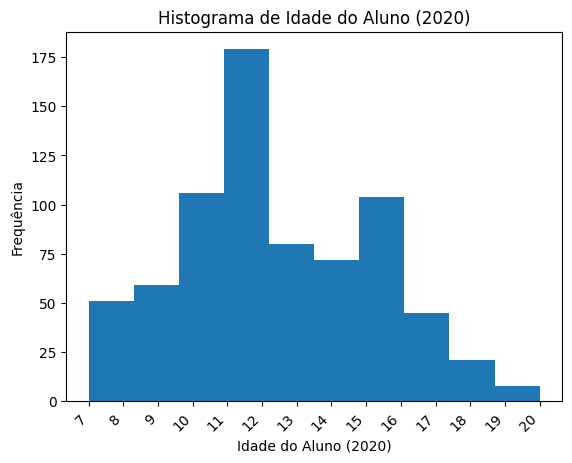

In [ ]:
# Assuming 'df' is your DataFrame

# Create the histogram
filtered_df = df[
    df['IDADE_ALUNO_2020_INT'].notna() &  # Not null
    (df['IDADE_ALUNO_2020_INT'] != 0) &  # Not zero
    (df['IDADE_ALUNO_2020_INT'] != 'Null')  # Not the string "Null"
]

plt.hist(filtered_df['IDADE_ALUNO_2020_INT'])  # Adjust 'bins' as needed

# Add labels and title
plt.xlabel('Idade do Aluno (2020)')
plt.ylabel('Frequência')
plt.title('Histograma de Idade do Aluno (2020)')
unique_ages = np.sort(filtered_df['IDADE_ALUNO_2020_INT'].unique())
plt.xticks(unique_ages, rotation=45, ha='right')  # Rotate labels if needed

# Display the histogram
plt.show()

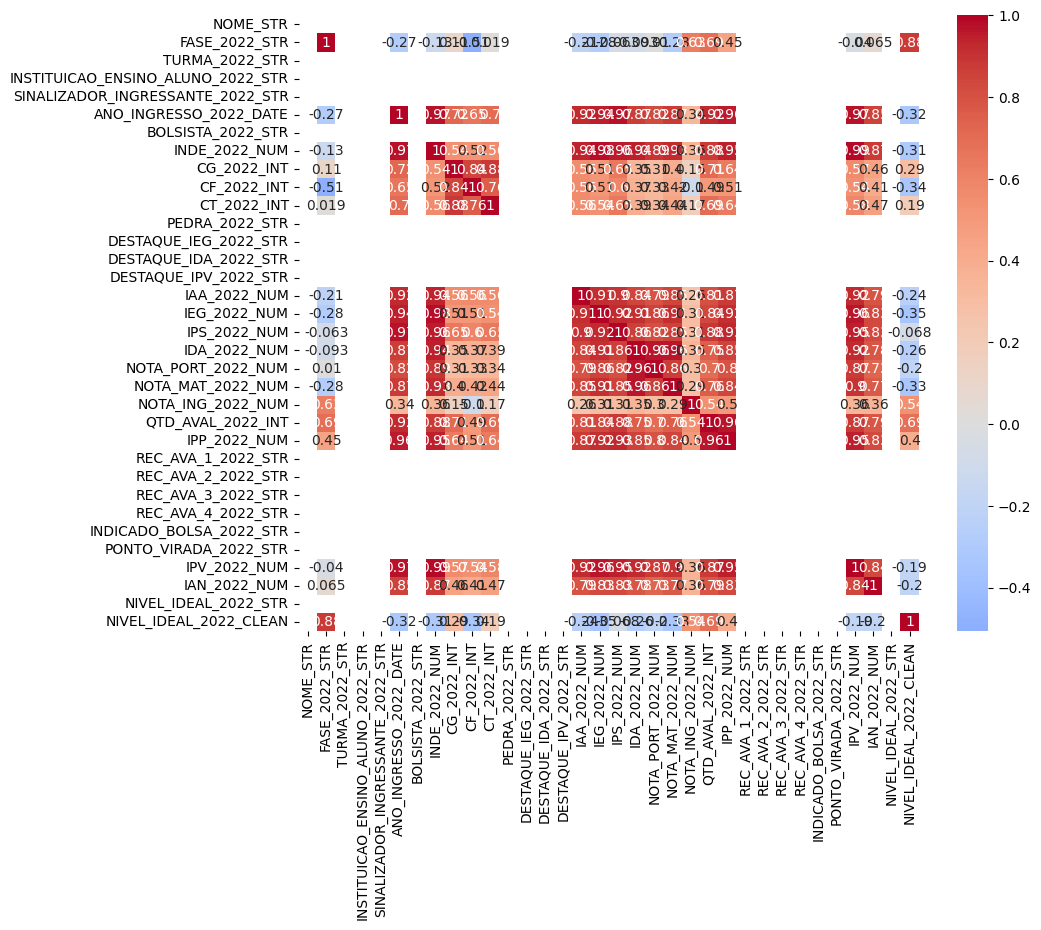

In [ ]:
analyse_corr(df_2022)

In [ ]:
#for column in df.columns:
#  # Exclude zeros and count values
#  counts = df[column][df[column] != 0].value_counts(dropna=False)

#  print(f"Value counts for {column} (excluding zeros):\n{counts}\n")

In [ ]:
df.columns

Index(['INDEX', 'NOME_STR', 'INSTITUICAO_ENSINO_ALUNO_2020_STR',
       'IDADE_ALUNO_2020_INT', 'ANOS_PM_2020_INT',
       'SINALIZADOR_INGRESSANTE_2020_STR', 'ANO_INGRESSO_2020_DATE',
       'FASE_TURMA_2020_STR', 'FASE_2020_STR', 'TURMA_2020_STR',
       'PONTO_VIRADA_2020_STR', 'INDE_2020_NUM', 'INDE_CONCEITO_2020_STR',
       'PEDRA_2020_STR', 'DESTAQUE_IEG_2020_STR', 'DESTAQUE_IDA_2020_STR',
       'DESTAQUE_IPV_2020_STR', 'IAA_2020_NUM', 'IEG_2020_NUM', 'IPS_2020_NUM',
       'IDA_2020_NUM', 'IPP_2020_NUM', 'IPV_2020_NUM', 'IAN_2020_NUM',
       'FASE_2021_STR', 'TURMA_2021_STR', 'INSTITUICAO_ENSINO_ALUNO_2021_STR',
       'SINALIZADOR_INGRESSANTE_2021_STR', 'ANO_INGRESSO_2021_DATE',
       'PEDRA_2021_STR', 'INDE_2021_NUM', 'IAA_2021_NUM', 'IEG_2021_NUM',
       'IPS_2021_NUM', 'IDA_2021_NUM', 'IPP_2021_NUM', 'REC_AVA_1_2021_STR',
       'REC_AVA_2_2021_STR', 'REC_AVA_3_2021_STR', 'REC_AVA_4_2021_STR',
       'PONTO_VIRADA_2021_STR', 'IPV_2021_NUM', 'IAN_2021_NUM',
       'NIVEL

In [ ]:
value_counts_list = []
for col in df.columns:
  value_counts_list.append(df[col].value_counts(dropna=False))
# Concatenate the value counts into a single DataFrame
df_value_counts = pd.concat(value_counts_list, axis=1)

# Reset index to make labels a column
df_value_counts = df_value_counts.reset_index()

# Rename columns for clarity
df_value_counts.columns = ['Value'] + [f'{col}_Count' for col in df.columns]

# Export to Excel
df_value_counts.to_excel('value_counts.xlsx')

In [ ]:
value_counts_list = []


filtered_df = df.filter(regex='NIVEL_IDEAL_2020_CLEAN')

for col in filtered_df.columns:
  value_counts_list.append(df[col].value_counts(dropna=False))
# Concatenate the value counts into a single DataFrame
df_value_counts = pd.concat(value_counts_list, axis=1)

# Reset index to make labels a column
df_value_counts = df_value_counts.reset_index()

# Rename columns for clarity
df_value_counts.columns = ['Value'] + [f'{col}_Count' for col in filtered_df.columns] # Use filtered_df.columns here
df_value_counts
# Export to Excel
#df_value_counts.to_excel('value_counts.xlsx')

,Value,NIVEL_IDEAL_2020_CLEAN_Count
0,NaN,619
1,1,172
2,2,155
3,3,122
4,ALFA,80
5,4,55
6,5,54
7,7,33
8,6,30
9,8,24


In [ ]:
df_value_counts.index

RangeIndex(start=0, stop=10, step=1)

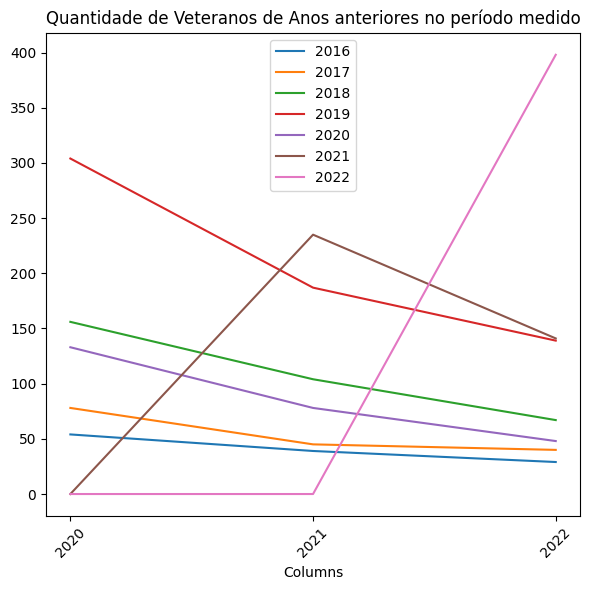

In [ ]:
value_counts_list = []


filtered_df = df.filter(regex='ANO_INGRESSO_[0-9]{4}_DATE')

for col in filtered_df.columns:
  value_counts_list.append(filtered_df[filtered_df[col] != '0'][col].value_counts(dropna=True))
# Concatenate the value counts into a single DataFrame
df_value_counts = pd.concat(value_counts_list, axis=1)

# Reset index to make labels a column
df_value_counts = df_value_counts.reset_index()

# Rename columns for clarity
df_value_counts.columns = ['Value'] + [f'{col}_Count' for col in filtered_df.columns] # Use filtered_df.columns here
df_value_counts.sort_values(by='Value', ascending=True)
df_value_counts = df_value_counts.transpose()

# Export to Excel
#df_value_counts.to_excel('value_counts.xlsx')
# Filter columns for ANO_INGRESSO_2020_DATE, ANO_INGRESSO_2021_DATE, ANO_INGRESSO_2022_DATE
filtered_df = df[['ANO_INGRESSO_2020_DATE', 'ANO_INGRESSO_2021_DATE', 'ANO_INGRESSO_2022_DATE']]

# Get unique years from column names
years = range(2016, 2023)  # Years 2020 to 2022

# Create a dictionary to store value counts for each year
year_counts = {}

for year in years:
    year_counts[year] = []
    for col in filtered_df.columns:
        # Filter for the specific year and count, converting year to string
        counts = filtered_df[filtered_df[col] == str(year)][col].count()
        year_counts[year].append(counts)



# Create a DataFrame from the year_counts dictionary
df_year_counts = pd.DataFrame.from_dict(year_counts, orient='index')
df_year_counts.index.name = 'Year'  # Set index name to 'Year'
df_year_counts.columns = filtered_df.columns  # Set column names

# Plot the line graph
fig, ax = plt.subplots(figsize=(6, 6))

# Iterate through rows (years) and plot data
for year in df_year_counts.index:
    ax.plot(df_year_counts.columns, df_year_counts.loc[year], label=year)

ax.set_xlabel('Columns')  # Changed x-axis label
ax.set_ylabel('')
ax.set_title('Quantidade de Veteranos de Anos anteriores no período medido')
ax.legend()
x_labels = [col.replace('ANO_INGRESSO_', '').replace('_DATE', '') for col in df_year_counts.columns]
ax.set_xticklabels(x_labels, rotation=45)  # Set trimmed labels and rotation

plt.tight_layout()
plt.show()

In [ ]:
df_year_counts.T

Year,2016,2017,2018,2019,2020,2021,2022
ANO_INGRESSO_2020_DATE,54,78,156,304,133,0,0
ANO_INGRESSO_2021_DATE,39,45,104,187,78,235,0
ANO_INGRESSO_2022_DATE,29,40,67,139,48,141,398


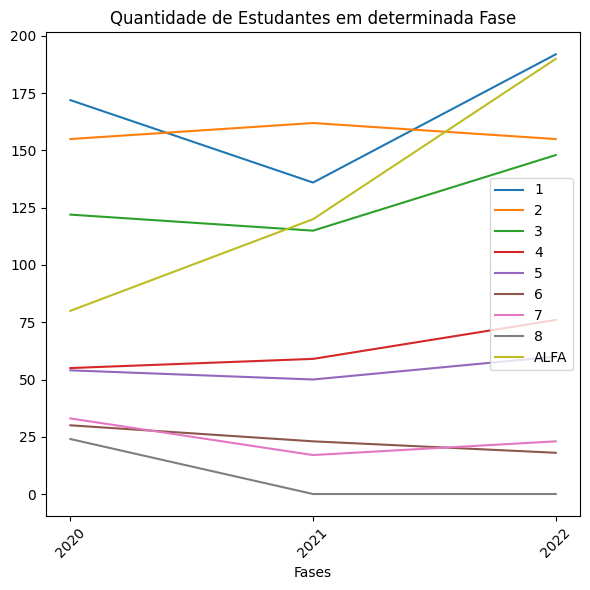

In [ ]:

filtered_df = df[['FASE_2020_STR', 'FASE_2021_STR', 'FASE_2022_STR']].dropna() # Keep it as a DataFrame
# Use numpy.unique() to get unique values (this part remains the same)
unique_values = np.unique(filtered_df.values)  # Use .values here to pass data to np.unique

# Remove empty strings from unique_values
unique_values = unique_values[unique_values != '']

#print(unique_values)

# Create a dictionary to store the counts
data_to_plot = {}
for value in unique_values:
    data_to_plot[value] = []
    for col in filtered_df.columns:  # Now you can access columns
        counts = filtered_df[filtered_df[col] == value][col].count()
        data_to_plot[value].append(counts)

# Create a DataFrame for plotting
df_to_plot = pd.DataFrame(data_to_plot, index=filtered_df.columns)

# Plot the data
fig, ax = plt.subplots(figsize=(6, 6))

for value in unique_values:
    ax.plot(df_to_plot.index, df_to_plot.loc[:, value], label=value)

# Customize the plot
ax.set_xlabel('Fases')
ax.set_ylabel('')
ax.set_title('Quantidade de Estudantes em determinada Fase')
ax.legend()

# Trim x-axis labels
x_labels = [col.replace('FASE_', '').replace('_STR', '') for col in df_to_plot.index]
ax.set_xticklabels(x_labels, rotation=45)  # Set trimmed labels and rotation

plt.tight_layout()
plt.show()


In [ ]:
value_counts_list = []


filtered_df = df.filter(regex='SINALIZADOR_INGRESSANTE_[0-9]{4}_STR')

for col in filtered_df.columns:
  value_counts_list.append(df[col].value_counts(dropna=False))
# Concatenate the value counts into a single DataFrame
df_value_counts = pd.concat(value_counts_list, axis=1)

# Reset index to make labels a column
df_value_counts = df_value_counts.reset_index()

# Rename columns for clarity
df_value_counts.columns = ['Value'] + [f'{col}_Count' for col in filtered_df.columns] # Use filtered_df.columns here
df_value_counts
# Export to Excel
#df_value_counts.to_excel('value_counts.xlsx')

,Value,SINALIZADOR_INGRESSANTE_2020_STR_Count,SINALIZADOR_INGRESSANTE_2021_STR_Count,SINALIZADOR_INGRESSANTE_2022_STR_Count
0,,619,662,482
1,Veterano,592,465,464
2,Ingressante,133,217,398


In [ ]:
value_counts_list = []


filtered_df = df.filter(regex='IDADE_ALUNO_[0-9]{4}_INT')

for col in filtered_df.columns:
  value_counts_list.append(df[col].value_counts(dropna=False))
# Concatenate the value counts into a single DataFrame
df_value_counts = pd.concat(value_counts_list, axis=1)

# Reset index to make labels a column
df_value_counts = df_value_counts.reset_index()

# Rename columns for clarity
df_value_counts.columns = ['Value'] + [f'{col}_Count' for col in filtered_df.columns] # Use filtered_df.columns here
df_value_counts
# Export to Excel
#df_value_counts.to_excel('value_counts.xlsx')

,Value,IDADE_ALUNO_2020_INT_Count
0,0,619
1,10,106
2,11,93
3,12,86
4,13,80
5,14,72
6,9,59
7,16,54
8,15,50
9,17,45


In [ ]:
value_counts_list = []


filtered_df = df.filter(regex='FASE_2020_STR')

for col in filtered_df.columns:
  value_counts_list.append(df[col].value_counts(dropna=False))
# Concatenate the value counts into a single DataFrame
df_value_counts = pd.concat(value_counts_list, axis=1)

# Reset index to make labels a column
df_value_counts = df_value_counts.reset_index()

# Rename columns for clarity
df_value_counts.columns = ['Value'] + [f'{col}_Count' for col in filtered_df.columns] # Use filtered_df.columns here
df_value_counts
# Export to Excel
#df_value_counts.to_excel('value_counts.xlsx')

,Value,FASE_2020_STR_Count
0,,619
1,1,172
2,2,155
3,3,122
4,ALFA,80
5,4,55
6,5,54
7,7,33
8,6,30
9,8,24


In [ ]:
#for column in df.columns:
#  df[column] = pd.to_numeric(df[column], errors='coerce')
#  average = np.mean(df[column][df[column] != 0])
#  print(f"Average of {column}: {average}")


In [ ]:
def count_combined_pedra_with_filter(df):
    """
    Calculates the occurrences of combined stone types,
    considering only rows where PONTO_VIRADA_2022_STR is "Sim".

    Args:
        df: Pandas DataFrame containing the data.

    Returns:
        A pandas Series with the counts of combined stone types.
    """

    # Filter the DataFrame
    filtered_df = df[
        (df['PEDRA_2020_STR'] != "None") &
        (df['PEDRA_2021_STR'] != "None") &
        (df['PEDRA_2022_STR'] != "None") &
        (df['PONTO_VIRADA_2022_STR'] == "Sim")  # Add the filter here
    ]

    # Combine the three PEDRA columns into a single string column
    filtered_df['combined_pedra'] = (
        filtered_df['PEDRA_2020_STR'] + " --> "
        + filtered_df['PEDRA_2021_STR'] + " --> "
        + filtered_df['PEDRA_2022_STR']
    )

    # Count the occurrences of each unique combined string
    pedra_counts = filtered_df['combined_pedra'].value_counts()
    return pedra_counts

In [ ]:
 count_combined_pedra_with_filter(df)

,count
combined_pedra,
--> --> Topázio,24
--> --> Ametista,17
Ametista --> Topázio --> Topázio,12
Topázio --> Topázio --> Topázio,11
Ametista --> Ametista --> Ametista,8
Topázio --> Ametista --> Ametista,7
Ametista --> Ametista --> Topázio,6
Topázio --> Ametista --> Topázio,5
--> Ametista --> Ametista,5


In [ ]:
def print_pedra_and_pattern_columns(df, pattern):
    """
    Prints the values of PEDRA columns (2020, 2021, 2022) and columns
    matching a specific pattern for rows where PONTO_VIRADA_2022_STR is "Sim"
    and all PEDRA columns are not null.

    Args:
        df: Pandas DataFrame containing the data.
        pattern: The pattern to search for in column names.
    """

    # Filter the DataFrame, adding the PEDRA not null conditions
    filtered_df = df[
        (df['PONTO_VIRADA_2022_STR'] == "Sim") &
        (df['PEDRA_2020_STR'] != "None") &
        (df['PEDRA_2021_STR'] != "None") &
        (df['PEDRA_2022_STR'] != "None")
    ]

    # Select the desired columns (same as before)
    pedra_columns = ['PEDRA_2020_STR', 'PEDRA_2021_STR', 'PEDRA_2022_STR']

    pattern_columns = [col for col in df.columns if pattern in col]
    selected_columns = pedra_columns + pattern_columns

    # Create a CSV output in memory
    output = io.StringIO()
    writer = csv.writer(output)

    # Write header row
    writer.writerow(selected_columns)

    # Write data rows
    for index, row in filtered_df[selected_columns].iterrows():
        writer.writerow(row.tolist())

    # Get the CSV content
    csv_content = output.getvalue()

    # Execute the code yourself to see the output
    #print(csv_content)
    return csv_content

In [ ]:
print_pedra_and_pattern_columns(df, 'IPV_2022_NUM')

'PEDRA_2020_STR,PEDRA_2021_STR,PEDRA_2022_STR,IPV_2022_NUM\r\nTopázio,Topázio,Topázio,9.5\r\n,,Topázio,8.5\r\n,,Topázio,8.611\r\n,,Topázio,9.25\r\n,Topázio,Ametista,8.778\r\n,,Ametista,8.5\r\n,,Topázio,8.611\r\nTopázio,Topázio,Topázio,9.75\r\nAmetista,Ágata,Ametista,8.833\r\nTopázio,Ametista,Ametista,8.444\r\nÁgata,Ágata,Ametista,8.833\r\nTopázio,Ametista,Topázio,9.083\r\n,Ametista,Topázio,8.583\r\nAmetista,Topázio,Topázio,9.333\r\n,,Ametista,8.444\r\n,,Topázio,9.0\r\n,,Topázio,8.417\r\n,,Topázio,8.944\r\nAmetista,Topázio,Topázio,9.292\r\n,Ametista,Ametista,8.583\r\nAmetista,Ametista,Topázio,8.389\r\nTopázio,Ametista,Topázio,8.458\r\nTopázio,Ametista,Topázio,8.889\r\n,Topázio,Topázio,9.083\r\n,Ametista,Ametista,8.556\r\nTopázio,Ametista,Ametista,8.444\r\nAmetista,Ametista,Ametista,8.389\r\n,,Ametista,9.5\r\n,Topázio,Topázio,9.111\r\n,Topázio,Ametista,9.667\r\nTopázio,,Topázio,10.0\r\n,Topázio,Topázio,8.667\r\n,,Ametista,9.417\r\n,,Topázio,8.417\r\n,,Ametista,8.667\r\n,,Topázio,9.083\r\

In [ ]:
# Filter out rows where any of the PEDRA columns are null
filtered_df = df.dropna(subset=['PEDRA_2020_STR', 'PEDRA_2021_STR', 'PEDRA_2022_STR'])

# Combine the three PEDRA columns into a single string column
filtered_df = df[
    df[['PEDRA_2020_STR', 'PEDRA_2021_STR', 'PEDRA_2022_STR']].apply(
        lambda row: all(
            (val is not None) and (val != "None") and (val != 0) and (val != '') for val in row
        ),
        axis=1,
    )
]

filtered_df['combined_pedra'] = (
    filtered_df['PEDRA_2020_STR'] + " --> "
    + filtered_df['PEDRA_2021_STR'] + " --> "
    + filtered_df['PEDRA_2022_STR']
)

# Count the occurrences of each unique combined string
pedra_counts = filtered_df['combined_pedra'].value_counts()
print(pedra_counts)

combined_pedra
Ametista --> Ametista --> Ametista    41
Ametista --> Ametista --> Ágata       35
Topázio --> Topázio --> Topázio       20
Topázio --> Ametista --> Ametista     20
Ametista --> Ágata --> Ágata          19
Ametista --> Ágata --> Ametista       18
Ametista --> Topázio --> Topázio      15
Ágata --> Ágata --> Ágata             12
Quartzo --> Quartzo --> Quartzo       11
Ametista --> Ametista --> Quartzo     11
Ametista --> Ametista --> Topázio      9
Ametista --> Topázio --> Ametista      9
Ágata --> Ágata --> Quartzo            8
Ágata --> Quartzo --> Quartzo          8
Ametista --> Ágata --> Quartzo         7
Topázio --> Topázio --> Ametista       6
Quartzo --> Quartzo --> Ágata          6
Topázio --> Ametista --> Topázio       6
Topázio --> Ametista --> Ágata         6
Quartzo --> Ágata --> Quartzo          5
Ametista --> Quartzo --> Ágata         5
Ágata --> Ametista --> Ágata           5
Ágata --> Ágata --> Ametista           4
Ágata --> Ametista --> Ametista        4
A

In [ ]:
filtered_df = df[
    (df['PEDRA_2020_STR'] == "Ametista") &
    (df['PEDRA_2021_STR'] == "Topázio") &
    (df['PEDRA_2022_STR'] == "Topázio")
]
filtered_df[['PEDRA_2020_STR','PEDRA_2021_STR','PEDRA_2022_STR','IPV_2020_NUM','IPV_2021_NUM','IPV_2022_NUM']]

,PEDRA_2020_STR,PEDRA_2021_STR,PEDRA_2022_STR,IPV_2020_NUM,IPV_2021_NUM,IPV_2022_NUM
116,Ametista,Topázio,Topázio,7.42,8.2,9.33
149,Ametista,Topázio,Topázio,8.61,10.0,8.12
151,Ametista,Topázio,Topázio,9.12,9.0,9.29
330,Ametista,Topázio,Topázio,7.44,9.8,8.17
402,Ametista,Topázio,Topázio,8.54,8.3,9.08
405,Ametista,Topázio,Topázio,9.17,9.4,9.58
480,Ametista,Topázio,Topázio,8.28,9.8,9.12
517,Ametista,Topázio,Topázio,9.06,8.9,8.29
521,Ametista,Topázio,Topázio,7.50,9.6,8.94
707,Ametista,Topázio,Topázio,8.33,8.4,8.62


In [ ]:
def count_stone_by_average(df, pattern, years):
    """
    Counts the occurrences of a stone type per average value of columns
    matching a pattern, excluding null numbers from the average, for
    multiple years.

    Args:
        df: Pandas DataFrame containing the data.
        pattern: Pattern to match columns for calculating average.
        years: A list of years to analyze.

    Returns:
        A dictionary where keys are years and values are Pandas Series
        containing the stone type counts per average value of matched
        columns for that year, excluding null numbers.
    """
    results = {}
    for year in years:
        stone_column = f"PEDRA_{year}_STR"  # Construct the stone column name
        pattern_year = f"{pattern}_{year}*"  # Construct the pattern for the current year

        # Select columns matching the pattern for the current year
        i_num_columns = df.filter(regex=pattern_year).columns

        # Calculate the average of I*_NUM columns for each row, excluding nulls
        df['i_num_avg'] = df[i_num_columns].apply(
            lambda row: row.dropna().mean(), axis=1
        )

        # Group by stone type and calculate the average of i_num_avg for the current year
        # stone_counts = df.groupby(stone_column)['i_num_avg'].mean() # Original line
        stone_counts = df.groupby(stone_column)['i_num_avg'].agg(['mean', 'count']) # Modified line

        # Rename columns for clarity
        stone_counts = stone_counts.rename(columns={'mean': 'average', 'count': 'quantity'})

        results[year] = stone_counts
        df = df.drop(columns=['i_num_avg']) # Reset the temporary column
    return results

In [ ]:
def count_stone_by_average(df, pattern, years):
    """
    Counts the occurrences of a stone type per average value of columns
    matching a pattern, excluding null numbers from the average, for
    multiple years.

    Args:
        df: Pandas DataFrame containing the data.
        pattern: Pattern to match columns for calculating average.
        years: A list of years to analyze.

    Returns:
        A dictionary where keys are years and values are Pandas Series
        containing the stone type counts per average value of matched
        columns for that year, excluding null numbers.
    """
    results = {}
    for year in years:
        stone_column = f"PEDRA_{year}_STR"  # Construct the stone column name
        pattern_year = f"{pattern}_{year}*"  # Construct the pattern for the current year

        # Select columns matching the pattern for the current year
        i_num_columns = df.filter(regex=pattern_year).columns

        # Calculate the average of I*_NUM columns for each row, excluding nulls and filtering out NA values
        df['i_num_avg'] = df[i_num_columns].apply(
            lambda row: row.dropna().mean() if row.notna().any() else np.nan, axis=1
        )

        # Debugging: Print rows where PEDRA_2020_STR is 'Topazio' and INDE_2020* values are greater than 8.2
        if year == 2020 and pattern == 'INDE':
            filtered_df = df[(df['PEDRA_2020_STR'] == 'Topázio') & (df[i_num_columns] > 8.2).any(axis=1)]
            print("Rows where 'Topazio' has INDE values greater than 8.2:")
            print(filtered_df[['PEDRA_2020_STR'] + list(i_num_columns)])

        # Group by stone type and calculate the average of i_num_avg for the current year
        stone_counts = df.groupby(stone_column)['i_num_avg'].agg(['mean', 'count'])

        # Rename columns for clarity
        stone_counts = stone_counts.rename(columns={'mean': 'average', 'count': 'quantity'})

        results[year] = stone_counts
        df = df.drop(columns=['i_num_avg']) # Reset the temporary column
    return results

In [ ]:
import numpy as np

def count_stone_by_average(df, pattern, years):
    """
    Counts the occurrences of a stone type per average value of columns
    matching a pattern, excluding null numbers from the average, for
    multiple years.

    Args:
        df: Pandas DataFrame containing the data.
        pattern: Pattern to match columns for calculating average.
        years: A list of years to analyze.

    Returns:
        A dictionary where keys are years and values are Pandas Series
        containing the stone type counts per average value of matched
        columns for that year, excluding null numbers.
    """
    results = {}
    for year in years:
        print(f"Processing year: {year}")
        stone_column = f"PEDRA_{year}_STR"  # Construct the stone column name
        pattern_year = f"\\b{pattern}_{year}\\b"   # Construct the pattern for the current year
        pattern_year = f"\\b{pattern}_{year}(_NUM)?\\b"
        # Select columns matching the pattern for the current year
        i_num_columns = df.filter(regex=pattern_year).columns
        print(f"Columns matching pattern: {i_num_columns}")

        # Calculate the average of I*_NUM columns for each row, excluding nulls and filtering out NA values
        df['i_num_avg'] = df[i_num_columns].apply(
            lambda row: row.dropna().mean() if row.notna().any() else np.nan, axis=1
        )
        print("Calculated i_num_avg for each row")

        # Debugging: Print rows where PEDRA_2020_STR is 'Topazio' and INDE_2020* values are greater than 8.2
        if year == 2020 and pattern == 'INDE':
            filtered_df = df[(df['PEDRA_2020_STR'] == 'Topázio') & (df[i_num_columns] > 8.2).any(axis=1)]
            print("Rows where 'Topazio' has INDE values greater than 8.2:")
            print(filtered_df[['PEDRA_2020_STR'] + list(i_num_columns)])

        # Group by stone type and calculate the average of i_num_avg for the current year
        stone_counts = df.groupby(stone_column)['i_num_avg'].agg(['mean', 'count'])
        print(f"Grouped by {stone_column} and calculated mean and count of i_num_avg")

        # Rename columns for clarity
        stone_counts = stone_counts.rename(columns={'mean': 'average', 'count': 'quantity'})
        print("Renamed columns to 'average' and 'quantity'")

        results[year] = stone_counts
        print(f"Stored results for year {year}")
        df = df.drop(columns=['i_num_avg']) # Reset the temporary column
        print("Dropped temporary column 'i_num_avg'")
    print("Finished processing all years")
    return results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_verticalbar(stone_counts, years, indice):
    """
    Plots a vertical bar chart showing the count and average of stone types for multiple years in the same plot.

    Args:
        stone_counts: A dictionary where keys are years and values are Pandas Series
                      containing the stone type counts per average value.
        years: A list of years to include in the plot.
        indice: The index/label for the plot (e.g., 'IAN').
    """

    # Create the column graph
    fig, ax = plt.subplots(figsize=(10, 6))  # Increased width for better visibility

    # Define width of each bar and spacing between groups
    bar_width = 0.2
    group_spacing = 0.1

    # Define the desired order of stone names
    desired_order = ['Quartzo', 'Ágata', 'Ametista', 'Topázio']

    # Get all stone names across all years, preserving the desired order
    filtered_stone_names = [name for name in desired_order if any(name in stone_counts[year].index for year in years)]

    # Calculate positions for bars using filtered stone names
    x_pos = np.arange(len(filtered_stone_names))

    # Iterate over the years and plot bars
    for i, year in enumerate(years):
        stone_count_series = stone_counts[year]

        # Extract the 'average' column for plotting
        filtered_counts = []
        for name in filtered_stone_names:
            try:
                # Accessing the 'average' column to get a single value for plotting
                filtered_counts.append(stone_count_series.loc[name, 'average'])
            except KeyError:
                filtered_counts.append(0)  # Append 0 if the stone type is not found in this year


        # Calculate bar positions for the current year
        bar_positions = x_pos + i * (bar_width + group_spacing)

        # Plot bars for the current year
        bars = ax.bar(bar_positions, filtered_counts, width=bar_width, label=year)

        # Add labels for count and average
        for bar, count, name in zip(bars, filtered_counts, filtered_stone_names):
            height = bar.get_height()
            # Using try-except block for cases when loc might raise KeyError
            try:
                # Accessing both 'quantity' and 'average' for the label
                count_value = int(stone_count_series.loc[name, 'quantity'])
                average_value = stone_count_series.loc[name, 'average']
            except KeyError:
                count_value = 0 # Use 0 if the key is not present
                average_value = 0 # Use 0 for average if key not found

            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"Qtde {count_value}\nMédia {average_value:.2f}", # Display 0 for count if key not found
                ha="center",
                va="bottom",
                fontsize=8  # Reduced font size for better readability
            )

    # Customize the plot
    ax.set_xlabel("")
    ax.set_ylabel(f"Valor Médio - {indice}")
    ax.set_title(f"Contagem de Pedras para o índice {indice} ({', '.join(map(str, years))})")
    current_ylim = ax.get_ylim()
    ax.set_ylim(current_ylim[0], current_ylim[1] * 1.2)  # Increase upper limit by 20%

    # Use filtered_stone_names as x-axis labels
    ax.set_xticks(x_pos + (len(years) - 1) * (bar_width + group_spacing) / 2)
    ax.set_xticklabels(filtered_stone_names)
    plt.xticks(rotation=45, ha="right")

    ax.legend()  # Add legend to distinguish years

    plt.show()

Processing year: 2020
Columns matching pattern: Index(['IAA_2020_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2020_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2020
Dropped temporary column 'i_num_avg'
Processing year: 2021
Columns matching pattern: Index(['IAA_2021_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2021_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2021
Dropped temporary column 'i_num_avg'
Processing year: 2022
Columns matching pattern: Index(['IAA_2022_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2022_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2022
Dropped temporary column 'i_num_avg'
Finished processing all years
{2020:                 average  quantity
PEDRA_2020_STR            

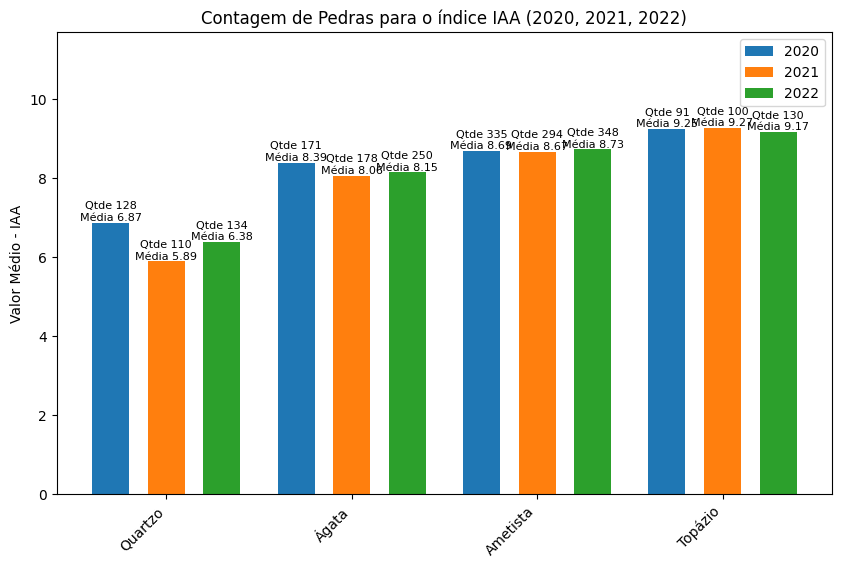

Processing year: 2020
Columns matching pattern: Index(['IPS_2020_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2020_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2020
Dropped temporary column 'i_num_avg'
Processing year: 2021
Columns matching pattern: Index(['IPS_2021_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2021_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2021
Dropped temporary column 'i_num_avg'
Processing year: 2022
Columns matching pattern: Index(['IPS_2022_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2022_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2022
Dropped temporary column 'i_num_avg'
Finished processing all years
{2020:                 average  quantity
PEDRA_2020_STR            

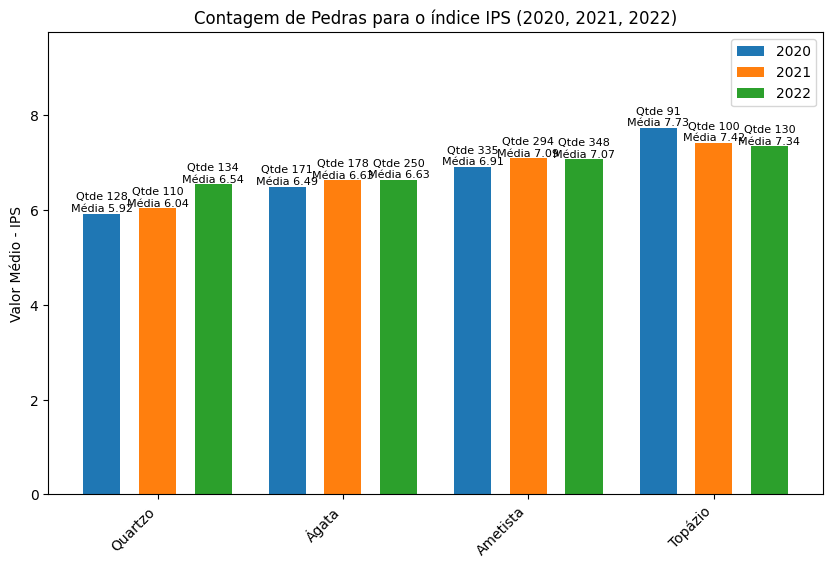

Processing year: 2020
Columns matching pattern: Index(['IPP_2020_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2020_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2020
Dropped temporary column 'i_num_avg'
Processing year: 2021
Columns matching pattern: Index(['IPP_2021_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2021_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2021
Dropped temporary column 'i_num_avg'
Processing year: 2022
Columns matching pattern: Index(['IPP_2022_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2022_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2022
Dropped temporary column 'i_num_avg'
Finished processing all years
{2020:                 average  quantity
PEDRA_2020_STR            

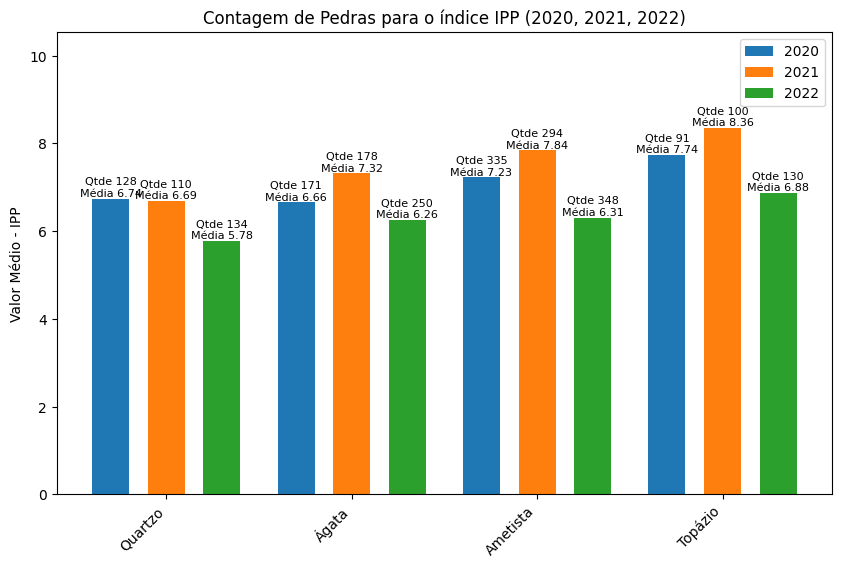

Processing year: 2020
Columns matching pattern: Index(['IPV_2020_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2020_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2020
Dropped temporary column 'i_num_avg'
Processing year: 2021
Columns matching pattern: Index(['IPV_2021_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2021_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2021
Dropped temporary column 'i_num_avg'
Processing year: 2022
Columns matching pattern: Index(['IPV_2022_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2022_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2022
Dropped temporary column 'i_num_avg'
Finished processing all years
{2020:                 average  quantity
PEDRA_2020_STR            

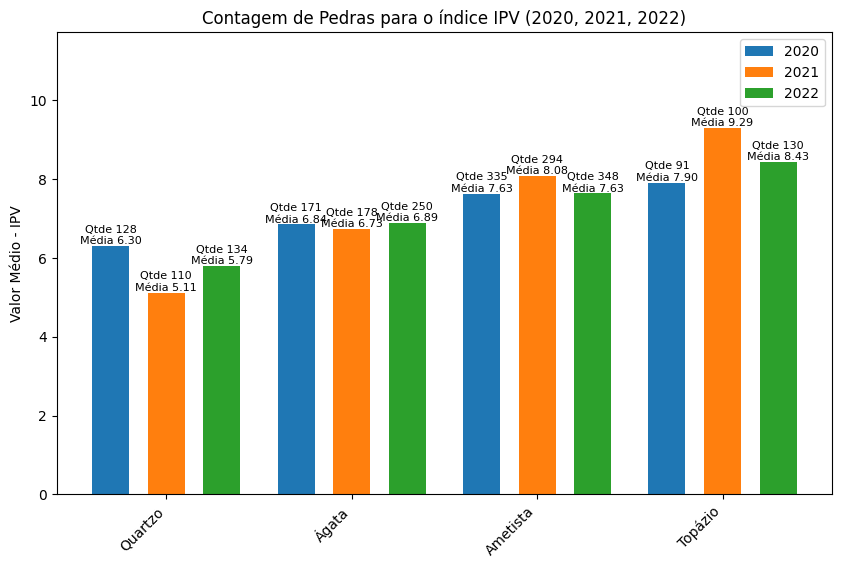

In [ ]:
patterns = ['IAA', 'IPS', 'IPP' , 'IPV' ]

years = [2020, 2021, 2022]

for pattern in patterns:
    stone_counts = count_stone_by_average(df, pattern, years)
    print(stone_counts)
    print()
    plot_verticalbar(stone_counts, years, pattern)

Processing year: 2020
Columns matching pattern: Index(['INDE_2020_NUM'], dtype='object')
Calculated i_num_avg for each row
Rows where 'Topazio' has INDE values greater than 8.2:
     PEDRA_2020_STR  INDE_2020_NUM
10          Topázio           10.0
27          Topázio            9.0
50          Topázio            9.0
52          Topázio            9.0
73          Topázio           10.0
...             ...            ...
1271        Topázio            9.0
1281        Topázio            9.0
1288        Topázio            9.0
1294        Topázio            9.0
1312        Topázio            8.5

[89 rows x 2 columns]
Grouped by PEDRA_2020_STR and calculated mean and count of i_num_avg
Renamed columns to 'average' and 'quantity'
Stored results for year 2020
Dropped temporary column 'i_num_avg'
Processing year: 2021
Columns matching pattern: Index(['INDE_2021_NUM'], dtype='object')
Calculated i_num_avg for each row
Grouped by PEDRA_2021_STR and calculated mean and count of i_num_avg
Renamed 

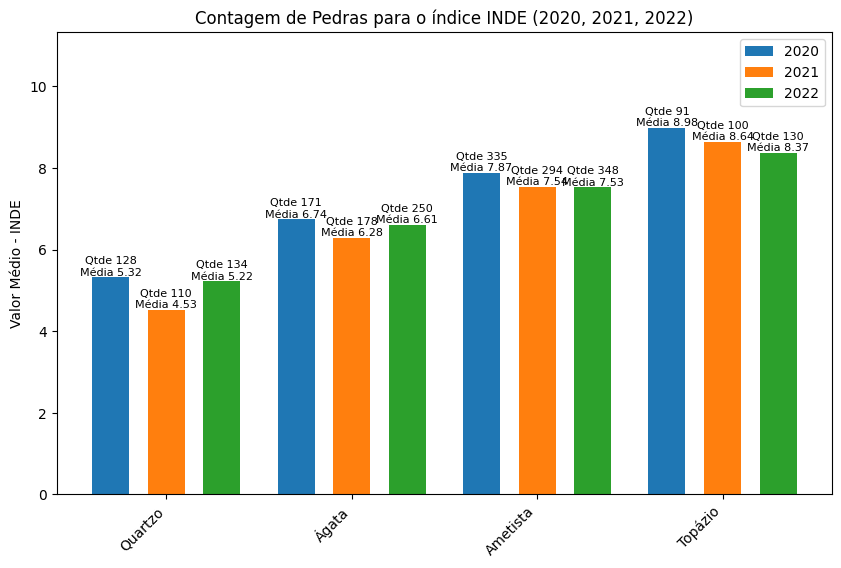

In [ ]:
stone_counts = count_stone_by_average(df, 'INDE', [2020, 2021, 2022])
print(stone_counts)
print()
plot_verticalbar(stone_counts, [2020, 2021, 2022], 'INDE')

In [ ]:
count_stones_per_year(df)

2020                                            2021              \
         Count                                           Count               
                 1   2   3   4   5   6   7  8 ALFA Total         1   2   3   
           619   0   0   0   0   0   0   0  0    0   619   662   0   0   0   
Ametista     0  85  73  55  26  24   7  16  8   41   335     0  64  64  47   
Quartzo      0  23  30  18  15  15  16   6  4    1   128     0  23  36  25   
Topázio      0  25  10  14   7   3   0   3  4   25    91     0  22  18  10   
Ágata        0  39  42  35   7  12   7   8  8   13   171     0  27  44  33   

                                     2022                                       
                                    Count                                       
           4   5   6   7 ALFA Total         1   2   3   4   5  6  7 ALFA Total  
           0   0   0   0    0   662   482   0   0   0   0   0  0  0    0   482  
Ametista  17  23  14  12   53   294     0  95  54  40  27  20  7  6   99   348  
Quartzo    7   9   1   1    8   110     0  19  23  45  11  14  3  9   10   134  
Topázio   10   8   0   3   29   100     0  30  17  19  12   9  5  2   36   130  
Ágata     25  10   8   1   30   178     0  48  61  44  26  17  3  6   45   250

OK 1
OK 2


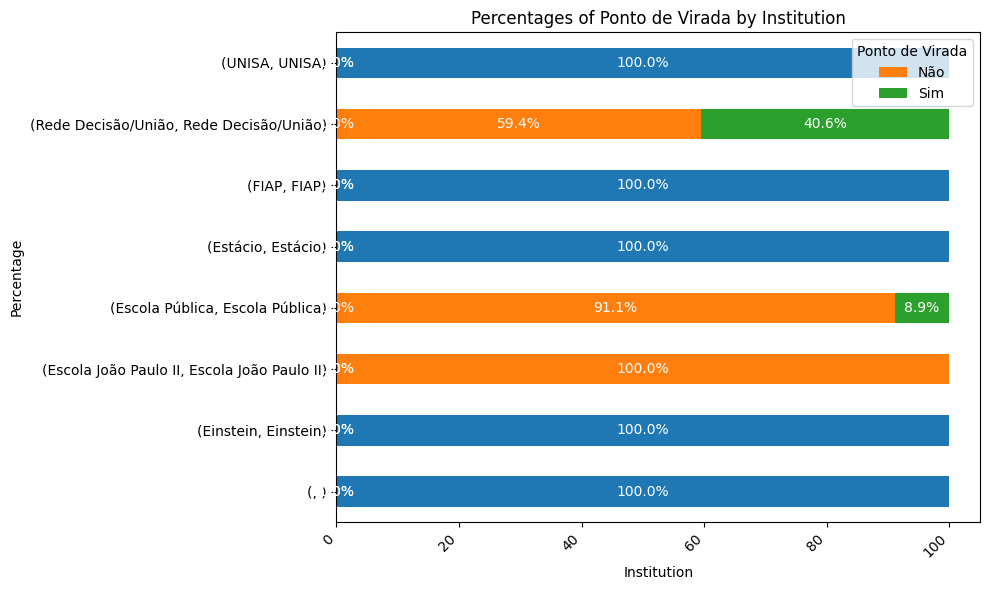

OK 1
OK 2


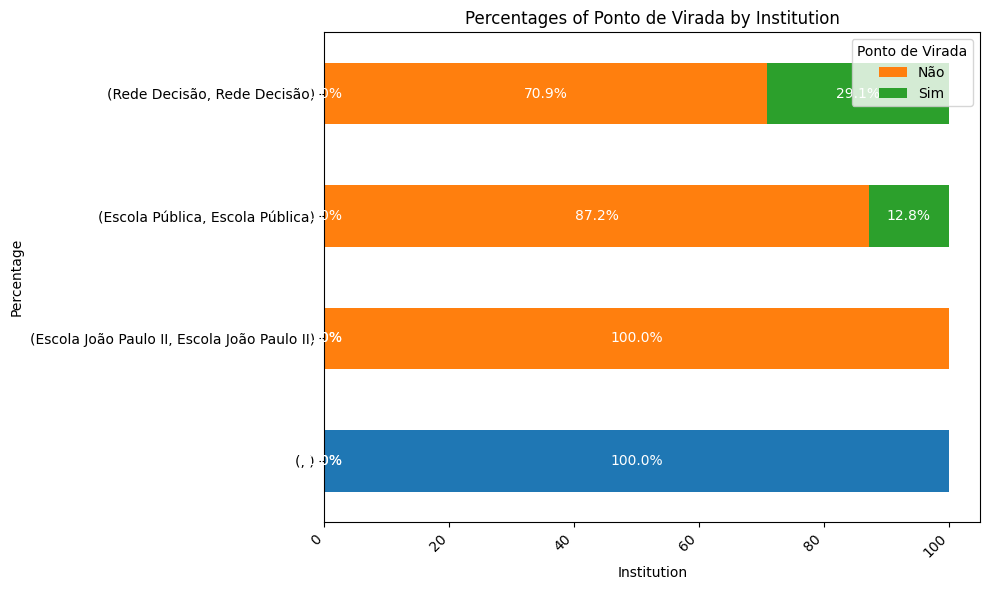

OK 1
OK 2


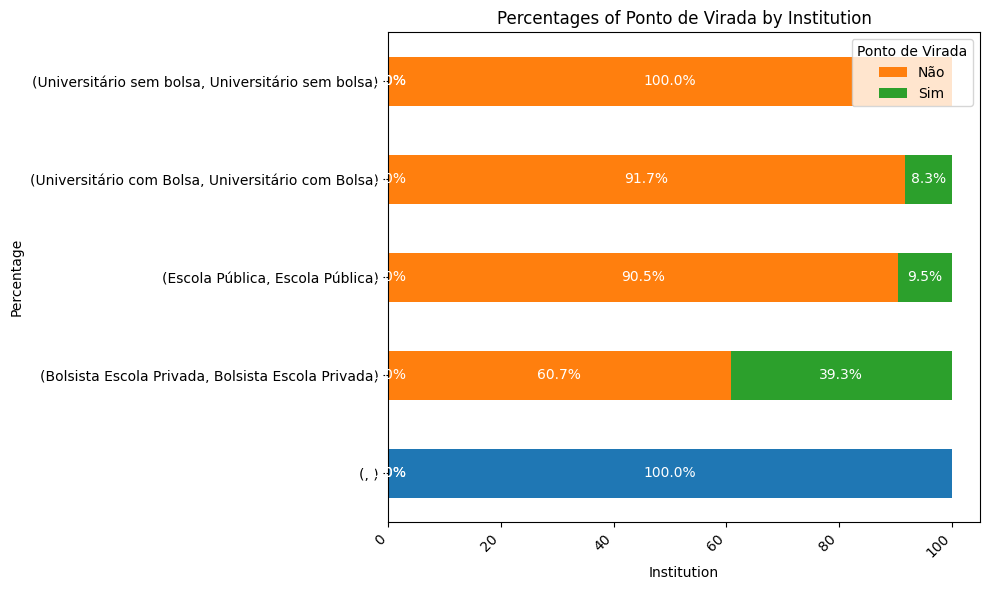

In [ ]:

# Replace 'None' with None
df.replace('None', np.nan, inplace=True)


nivel_ideal_counts = {}

# Iterate through the years
for year in [2020, 2021, 2022]:
    column_name1 = f'INSTITUICAO_ENSINO_ALUNO_{year}_STR'
    column_name2 = f'PONTO_VIRADA_{year}_STR'
    # Check if the column exists in the DataFrame

    if column_name1 in df.columns:
        print("OK 1")

    if column_name2 in df.columns:
        print("OK 2")


    if column_name1 in df.columns and column_name2 in df.columns:
        # Filter out rows with None values in both columns
        filtered_df = df.dropna(subset=[column_name1, column_name2])

        # Group data by INSTITUICAO_ENSINO_ALUNO and PONTO_DE_VIRADA and count occurrences
        grouped_data = filtered_df.groupby([column_name1, column_name2]).size()

        # Calculate percentages
        percentages = grouped_data.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

        # Create a bar plot
        fig, ax = plt.subplots(figsize=(10, 6))

        percentages.unstack().plot(kind='barh', stacked=True, ax=ax)

        # Customize the plot
        ax.set_xlabel("Institution")
        ax.set_ylabel("Percentage")
        ax.set_title("Percentages of Ponto de Virada by Institution")
        ax.legend(title="Ponto de Virada")
        plt.xticks(rotation=45, ha='right')

        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{width:.1f}%', (x + width/2, y + height/2), ha='center', va='center', color='white')

        plt.tight_layout()
        plt.show()

In [ ]:
#df = df.drop('IPS_2020_2021_DIFF', axis=1)
#df = df.drop('IPS_2021_2022_DIFF', axis=1)

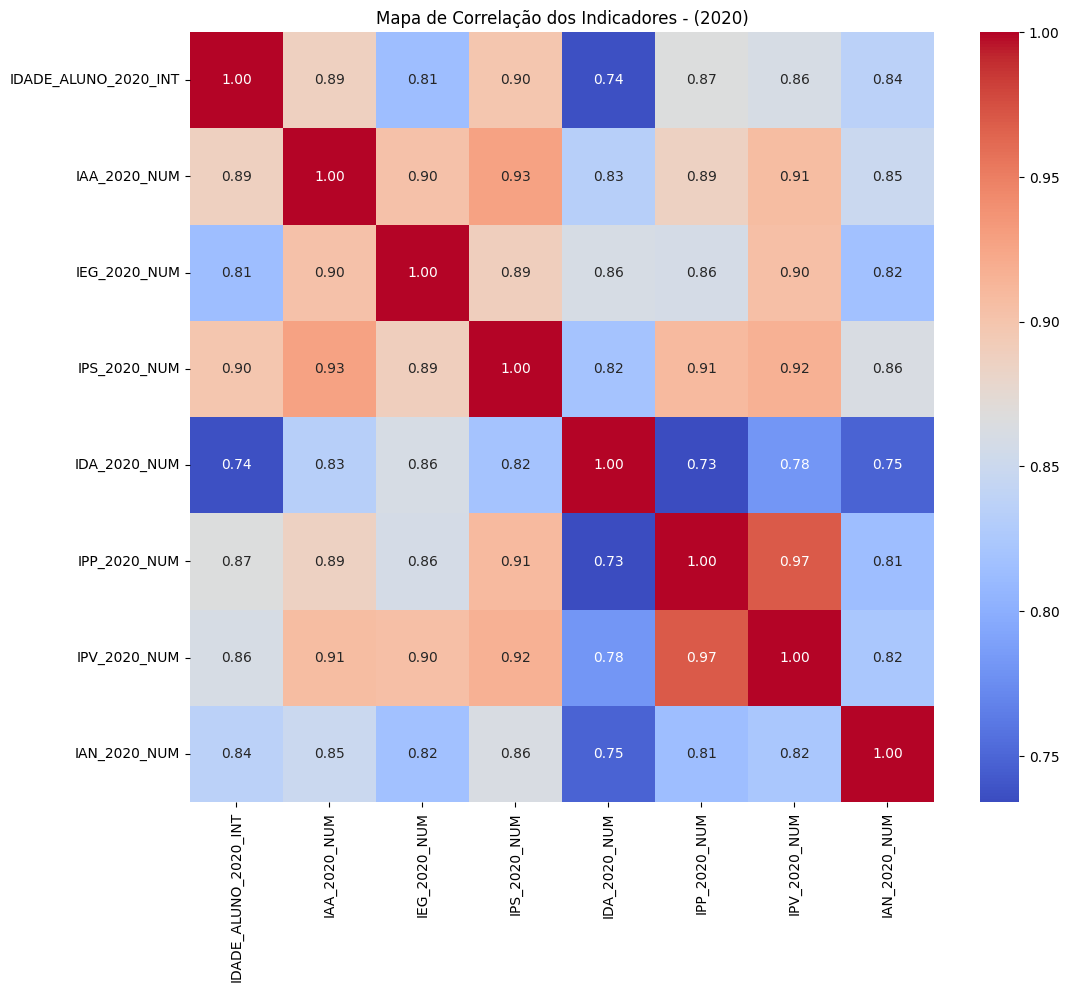

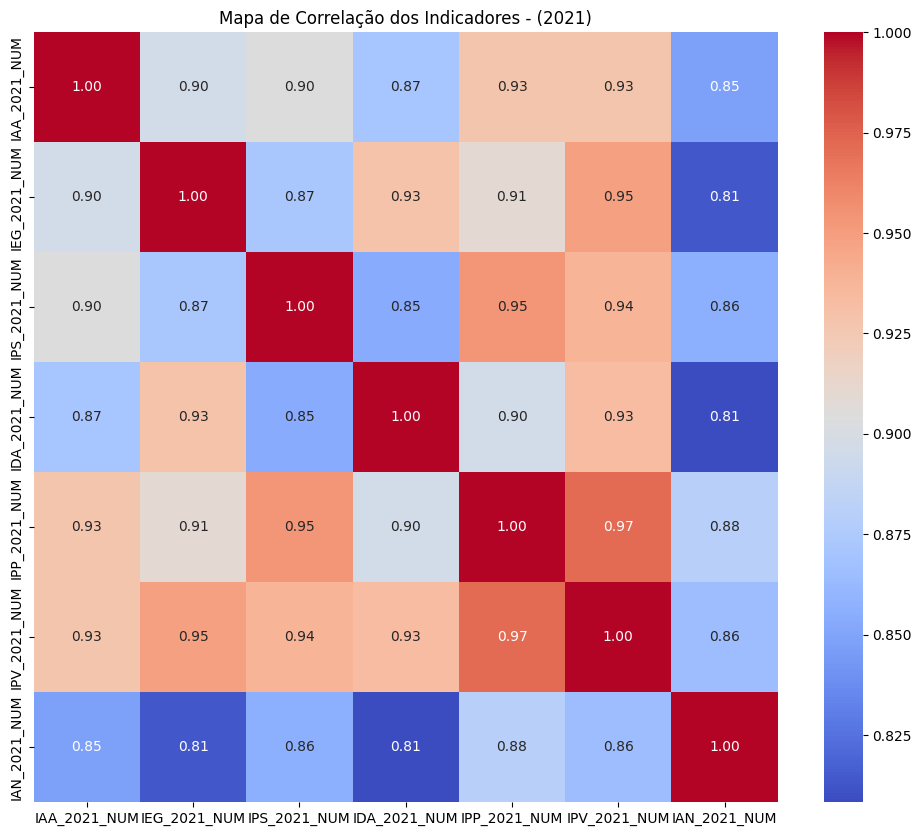

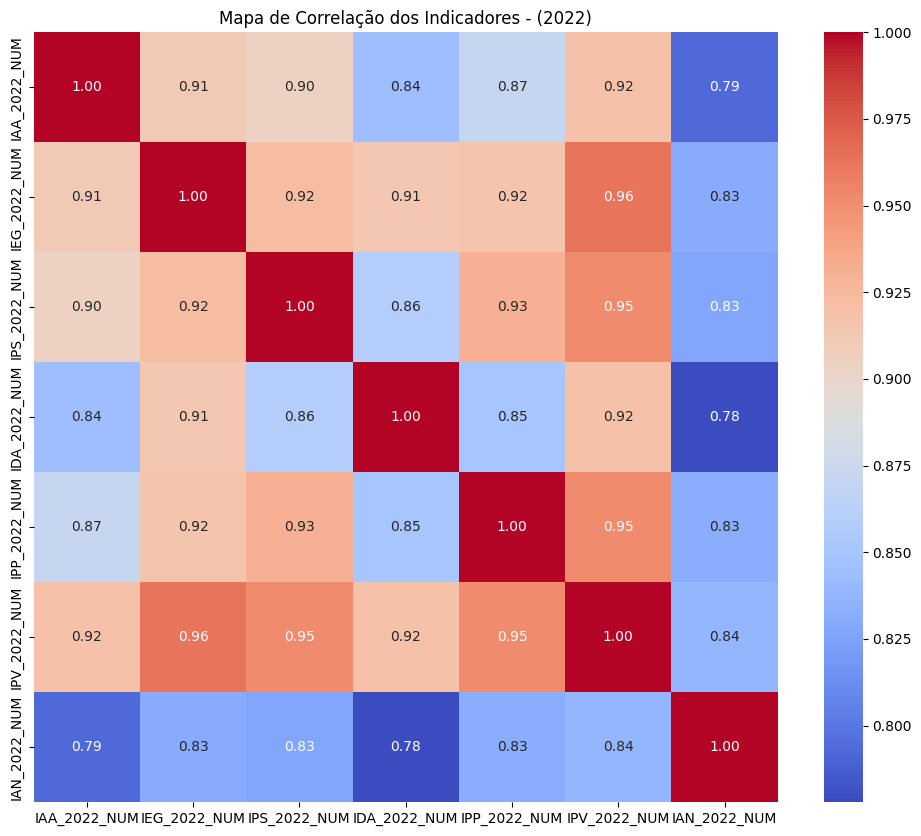

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap_with_pattern_and_years(df, patterns, years):
    """
    Generates heatmaps of correlations for columns matching specified patterns and a list of years.

    Args:
        df (pd.DataFrame): The input DataFrame.
        patterns (list): A list of patterns (strings or regular expressions) to filter columns.
        years (list): A list of years to consider in the column names.

    Returns:
        None (Displays the heatmaps).
    """

    for year in years:
        # Filter columns based on patterns and year
        filtered_cols = [col for col in df.columns
                         if any(pattern in col for pattern in patterns) and str(year) in col]

        # Select only numeric columns from the filtered columns
        numeric_filtered_cols = df[filtered_cols].select_dtypes(include=np.number).columns

        # Calculate correlations using only numeric columns
        if len(numeric_filtered_cols) > 0:  # Check if there are any numeric columns to avoid errors
            correlations = df[numeric_filtered_cols].corr()

            # Generate heatmap
            plt.figure(figsize=(12, 10))  # Adjust figure size as needed
            sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title(f'Mapa de Correlação dos Indicadores - ({year})')
            plt.show()
        else:
            print(f"No numeric columns found for year {year} with the specified patterns.")

# Example usage
# Assuming 'df' is your DataFrame

# Define patterns
patterns = ['IPV', 'IPP', 'IPS', 'IAA', 'IDA', 'IEG' , 'IAN']  # Replace with your desired patterns

# Define years
years = [2020, 2021, 2022]  # Replace with your desired years

# Generate heatmaps for each year
heatmap_with_pattern_and_years(df, patterns, years)


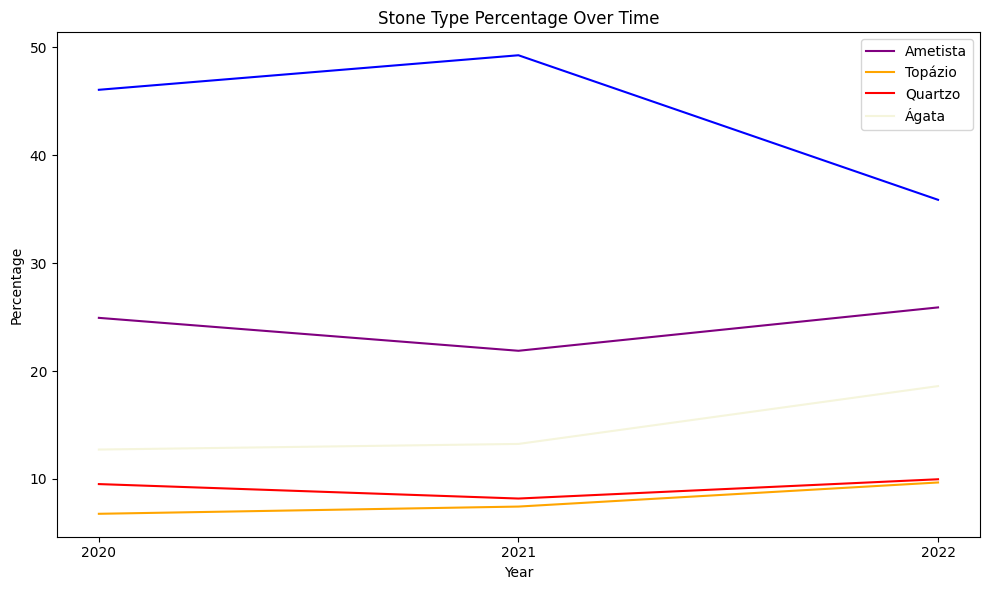

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

stone_colors = {
    'Ametista': 'purple',
    'Ágata': 'beige',
    'Topázio': 'orange',
    'Quartzo': 'red',
    # Add more stones and colors as needed
}

# Select columns matching the pattern
filtered_df = df.filter(regex='PEDRA_[0-9]{4}_STR')

# Extract years from column names
years = [int(col.split('_')[1]) for col in filtered_df.columns]

# Create an empty dictionary to store the value counts for each year
year_counts = {}

# Calculate value counts for each year
for col in filtered_df.columns:
    year = int(col.split('_')[1])
    year_counts[year] = filtered_df[col].value_counts()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a set to store unique stone names
unique_stones = set()

# Iterate over the years and their counts to get unique stone names
for year, value_counts in year_counts.items():
    for stone in value_counts.index:
        unique_stones.add(stone)

# Plot separate lines for each stone (percentage)
for stone in unique_stones:
    counts = []
    for year in years:
        total_count = year_counts[year].sum()  # Calculate total count for the year
        if stone in year_counts[year].index:
            counts.append(year_counts[year][stone] / total_count * 100)
        else:
            counts.append(0)
    ax.plot(years, counts, label=stone, color=stone_colors.get(stone, 'blue'))

# Customize the plot
ax.set_xlabel("Year")
ax.set_ylabel("Percentage")
ax.set_title("Stone Type Percentage Over Time")
ax.legend()
plt.xticks(years)
plt.tight_layout()
plt.show()

In [ ]:

def plot_stone_over_time(df):
    """
    Plots the occurrence of each stone type over the years.

    Args:
        df (pd.DataFrame): The input DataFrame containing stone data.
                          It should have columns like 'PEDRA_2020_STR',
                          'PEDRA_2021_STR', 'PEDRA_2022_STR' etc.
    """

    # Assuming your stone columns are named like 'PEDRA_YYYY_STR'
    stone_columns = [col for col in df.columns if col.startswith("PEDRA_") and col.endswith("_STR")]
    years = [int(col.split("_")[1]) for col in stone_columns]  # Extract years from column names

    # Convert stone columns to string type and replace empty strings with NaN
    for col in stone_columns:
        df[col] = df[col].astype(str).replace({'': np.nan, '0': np.nan})

    # Get unique stone types, excluding NaN values
    all_stones = pd.unique(df[stone_columns].values.ravel())
    all_stones = [x for x in all_stones if str(x) != 'nan']
    # Calculate stone counts for each year
    stone_counts_by_year = {}
    for stone in all_stones:
        stone_counts_by_year[stone] = [df[col][df[col] == stone].count() for col in stone_columns]

    # Create the plot
    plt.figure(figsize=(10, 6))
    for stone, counts in stone_counts_by_year.items():
        plt.plot(years, counts, label=stone)

    plt.xlabel("")
    plt.ylabel("")
    plt.title("Quantidade dos perfis das pedras ao longo de 2020 a 2022")
    plt.xticks(years)
    plt.legend()

    plt.show()

# Example usage:
# count_stones_per_year(df) # Assuming you have this function defined as well
# plot_stone_over_time(df)

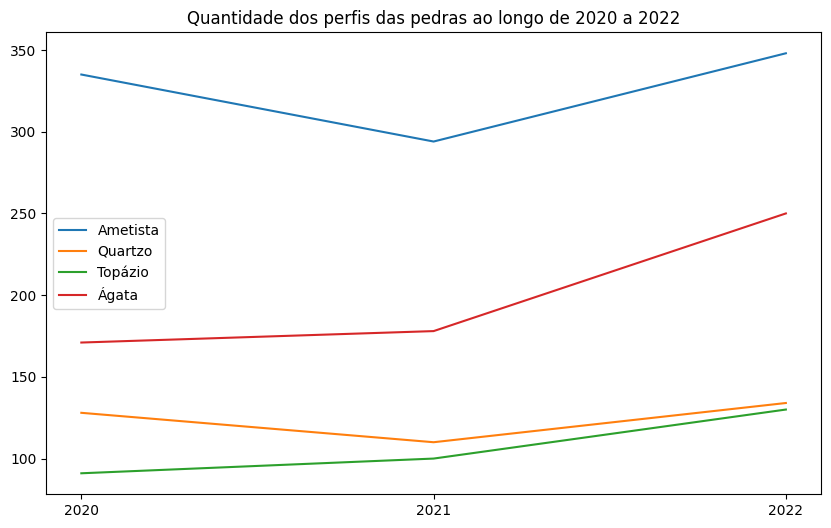

In [ ]:
plot_stone_over_time(df)

In [ ]:
# Assuming you have your DataFrame 'df'

# Create a dictionary to store the counts
nivel_ideal_counts = {}

# Iterate through the years
for year in [2020, 2021, 2022]:
    column_name = f'NIVEL_IDEAL_{year}_CLEAN'

    # Check if the column exists in the DataFrame
    if column_name in df.columns:
# Count values and handle NaN
        nivel_ideal_counts[year] = df[(df[column_name] != '''null''') ][column_name].value_counts()
    print(nivel_ideal_counts)
    print()

{2020: NIVEL_IDEAL_2020_CLEAN
1       172
2       155
3       122
ALFA     80
4        55
5        54
7        33
6        30
8        24
Name: count, dtype: int64}

{2020: NIVEL_IDEAL_2020_CLEAN
1       172
2       155
3       122
ALFA     80
4        55
5        54
7        33
6        30
8        24
Name: count, dtype: int64, 2021: NIVEL_IDEAL_2021_CLEAN
2       177
3       171
4        73
1        69
5        56
ALFA     52
6        41
7        36
8         7
Name: count, dtype: int64}

{2020: NIVEL_IDEAL_2020_CLEAN
1       172
2       155
3       122
ALFA     80
4        55
5        54
7        33
6        30
8        24
Name: count, dtype: int64, 2021: NIVEL_IDEAL_2021_CLEAN
2       177
3       171
4        73
1        69
5        56
ALFA     52
6        41
7        36
8         7
Name: count, dtype: int64, 2022: NIVEL_IDEAL_2022_CLEAN
2       218
3       207
1        96
4        85
ALFA     71
5        63
6        52
7        48
8        22
Name: count, dtype: int64}



In [ ]:
# List of patterns
patterns = [r'PEDRA']

# Combine patterns into a single regular expression
combined_pattern = '|'.join(patterns)

# Filter columns based on the combined pattern
list_pedra = list(np.unique(df.filter(regex=combined_pattern).filter(regex='202[0-9]').values.astype(str).flatten()))

# Remove 'None' only if it exists in the list
if 'None' in list_pedra:
    list_pedra.remove('None')

if 'nan' in list_pedra:
    list_pedra.remove('nan')

new_list_pedra = [x for x in list_pedra if x]
# Print the filtered columns
print(new_list_pedra)


['Ametista', 'Quartzo', 'Topázio', 'Ágata']


In [ ]:
count_stones_per_year(df)

2020                                        2021                   \
         Count                                       Count                    
             1   2   3 ALFA   4   5   7  8   6 Total     1   2 ALFA   3   5   
Ametista    85  73  55   41  26  24  16  8   7   335    64  64   53  47  23   
Quartzo     23  30  18    1  15  15   6  4  16   128    23  36    8  25   9   
Topázio     25  10  14   25   7   3   3  4   0    91    22  18   29  10   8   
Ágata       39  42  35   13   7  12   8  8   7   171    27  44   30  33  10   

                            2022                                  
                           Count                                  
           4   6   7 Total  ALFA   1   2   3   4   5  6  7 Total  
Ametista  17  14  12   294    99  95  54  40  27  20  7  6   348  
Quartzo    7   1   1   110    10  19  23  45  11  14  3  9   134  
Topázio   10   0   3   100    36  30  17  19  12   9  5  2   130  
Ágata     25   8   1   178    45  48  61  44  26  17  3  6   250

In [ ]:

# Get unique NIVEL_IDEAL values (handling NaN for NIVEL_IDEAL)
nivel_ideal_values = []
for year in ['2020', '2021', '2022']:
    if f'NIVEL_IDEAL_{year}_STR' in df.columns: # Check if column exists
        nivel_ideal_values.extend(df[df[f'NIVEL_IDEAL_{year}_STR'] != 'None'][f'NIVEL_IDEAL_{year}_STR'].unique())


# Create a dictionary to store the data for the table
table_data = {}

# Iterate through unique NIVEL_IDEAL values
for nivel in nivel_ideal_values:
    table_data[nivel] = {'2020': {}, '2021': {}, '2022': {}}
    for year in [2020, 2021, 2022]:
        for stone in new_list_pedra:
            # Calculate percentage for each stone and year (using fillna within the loop)
            if f'PEDRA_{year}_STR' in df.columns: #check if column exists
                df[f'PEDRA_{year}_STR'] = df[f'PEDRA_{year}_STR'].fillna('None')
                # Filter for the specific stone and year and calculate the total count
                total_count = df[(df[f'PEDRA_{year}_STR'] == stone) & (df[f'PEDRA_{year}_STR'] != 'None')][f'PEDRA_{year}_STR'].count()
                # Filter by stone, year and nivel and calculate the count
                if f'NIVEL_IDEAL_{year}_STR' in df.columns: #check if column exists
                    stone_count = df[(df[f'PEDRA_{year}_STR'] == stone) & (df[f'PEDRA_{year}_STR'] != 'None') & (df[f'NIVEL_IDEAL_{year}_STR'] == nivel)][f'PEDRA_{year}_STR'].count()
                else:
                    stone_count = 0
                percentage = (stone_count / total_count) * 100 if total_count > 0 else 0
                table_data[nivel][str(year)][stone] = percentage

# Convert the dictionary to a list of lists for tabulate (modified)
table_rows = []
for nivel, years in table_data.items():
    for year, stones in years.items():
        row = [f'{nivel} {year}']
        row.extend([f"{stones.get('Topázio', 0):.2f}%", f"{stones.get('Ametista', 0):.2f}%",
                     f"{stones.get('Ágata', 0):.2f}%", f"{stones.get('Quartzo', 0):.2f}%"])
        table_rows.append(row)

table_rows = sorted(table_rows, key=lambda row: row[0])

# Create the table using tabulate (modified)
headers = new_list_pedra
table = tabulate(table_rows, headers=headers, tablefmt='grid')

# Print the table
print(table)

+------------------------------+------------+-----------+-----------+---------+
|                              | Ametista   | Quartzo   | Topázio   | Ágata   |
+==============================+============+===========+===========+=========+
| 2020                         | 0.00%      | 0.00%     | 0.00%     | 0.00%   |
+------------------------------+------------+-----------+-----------+---------+
| 2021                         | 0.00%      | 0.00%     | 0.00%     | 0.00%   |
+------------------------------+------------+-----------+-----------+---------+
| 2022                         | 0.00%      | 0.00%     | 0.00%     | 0.00%   |
+------------------------------+------------+-----------+-----------+---------+
| ALFA  (2o e 3o ano) 2020     | 0.00%      | 0.00%     | 0.00%     | 0.00%   |
+------------------------------+------------+-----------+-----------+---------+
| ALFA  (2o e 3o ano) 2021     | 25.00%     | 6.80%     | 3.37%     | 0.91%   |
+------------------------------+--------

In [ ]:
nivel_ideal_values = df['NIVEL_IDEAL_2022_STR'].fillna('None').unique() # Handle NaN here

for nivel in nivel_ideal_values:
    table_data[nivel] = {'2020': {}, '2021': {}, '2022': {}}
    for year in [2020, 2021, 2022]:
        for stone in ['Topázio', 'Ametista', 'Ágata', 'Quartzo']:
            # Calculate percentage for each stone and year (using fillna within the loop)
            df[f'PEDRA_{year}_STR'] = df[f'PEDRA_{year}_STR'].fillna('None')
            total_count = df[f'PEDRA_{year}_STR'].value_counts().sum()
            stone_count = df[(df[f'PEDRA_{year}_STR'] == stone) & (df['NIVEL_IDEAL_2022_STR'] == nivel)][f'PEDRA_{year}_STR'].count()
            percentage = (stone_count / total_count) * 100 if total_count > 0 else 0
            table_data[nivel][str(year)][stone] = percentage

In [ ]:
def arima_predictions_multivariate(data, order, steps):
    # Data preprocessing (example: differencing)
    data_diff = data.diff().dropna()

    model = ARIMA(data_diff, order=order)
    model_fit = model.fit()

    # Model diagnostics
    residuals = model_fit.resid

    # Plotting residuals for each column
    for col in residuals.columns:
        fig, ax = plt.subplots(1,2)
        residuals[col].plot(title=f"Residuals for {col}", ax=ax[0])
        residuals[col].plot(kind='kde', title='Density', ax=ax[1])
        st.pyplot(fig)
        st.write(sm.stats.acorr_ljungbox(residuals[col], lags=[10], return_df=True))

    predictions = model_fit.predict(start=len(data_diff), end=len(data_diff)+steps-1)

    return predictions

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

def predict_success(df, features, target, model_type, test_size=0.2, random_state=42):
  """
  Predizer sucesso usando modelos de classificação ou regressão.

  Args:
    df: Pandas DataFrame contendo os dados.
    features: List of column names to be used as features.
    target: Column name to be used as the target variable.
    model_type: Type of model to use ('classification' or 'regression').
    test_size: Proportion of data to use for testing (default: 0.2).
    random_state: Random seed for reproducibility (default: 42).

  Returns:
    A dictionary containing the trained model, accuracy/MSE score, predictions,
    and a DataFrame with 'NOME' and index for successful and unsuccessful predictions.
  """

  threshold = 0.1  # Threshold for regression predictions

  # 1. Drop rows with nulls or empty strings in features OR target
  df_cleaned = df.dropna(subset=features + [target])  # Drop if missing in any feature or target
  df_cleaned = df_cleaned[~df_cleaned[features + [target]].eq('').any(axis=1)]  # Drop if empty string in any feature or target

  df_dropna = df_cleaned

  # Check if there's any data left after filtering
  if df_cleaned.empty:
        return "Not enough data with complete feature and target values for prediction."

  # 2. Split data into training and testing sets
  X = df_cleaned[features]
  y = df_cleaned[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  # Choose model based on model_type:
  # Classification: Logistic Regression, Decision Tree - Classification, Random Forest - Classification
  # Regression: Linear Regression, Decision Tree - Regression, Random Forest - Regression
  if model_type == 'Logistic Regression':
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state)
    }
  elif model_type == 'Decision Tree - Classification':
    models = {
        'Decision Tree - Classification': DecisionTreeClassifier(random_state=random_state)
    }
  elif model_type == 'Random Forest - Classification':
    models = {
        'Random Forest - Classification': RandomForestClassifier(random_state=random_state)
        }
  elif model_type == 'Linear Regression':
    models = {
        'Linear Regression': LinearRegression()
    }
  elif model_type == 'Decision Tree - Regression':
    models = {
        'Decision Tree - Regression': DecisionTreeRegressor(random_state=random_state)
    }

  elif model_type == 'Random Forest - Regression':
    models = {
        'Random Forest - Regression': RandomForestRegressor(random_state=random_state)
}
  else:
    return f"Invalid model type. Please choose:\n'Logistic Regression' or \n'Decision Tree - Classification' or \n'Random Forest - Classification' or \n'Linear Regression' or \n'Decision Tree - Regression' or \n'Random Forest - Regression' or \n'regression'."


  results = {}
  for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    sorted_predictions_df = pd.DataFrame()  # Initialize here


# Evaluate the model and get indices
    if model_type == 'Logistic Regression' or model_type == 'Decision Tree - Classification' or model_type == 'Random Forest - Classification':
      score = accuracy_score(y_test, predictions)

    # Create a DataFrame with 'NOME' and index for successful predictions
      successful_df = df_dropna.loc[X_test[y_test == predictions].index, ['NOME_STR']].copy()
      successful_df['Index'] = successful_df.index
      successful_df.rename(columns={'NOME_STR': 'NOME'}, inplace=True)
      # Filter out empty strings in 'NOME' column
      successful_df = successful_df[successful_df['NOME'] != '']

      # Create a DataFrame with 'NOME' and index for unsuccessful predictions
      unsuccessful_df = df_dropna.loc[X_test[y_test != predictions].index, ['NOME_STR']].copy()
      unsuccessful_df['Index'] = unsuccessful_df.index
      unsuccessful_df.rename(columns={'NOME_STR': 'NOME'}, inplace=True)
      # Filter out empty strings in 'NOME' column
      unsuccessful_df = unsuccessful_df[unsuccessful_df['NOME'] != '']

    else:
      score = mean_squared_error(y_test, predictions)

      # Create a DataFrame with 'NOME', index, and predictions
      prediction_df = df_dropna.loc[X_test.index, ['NOME_STR']].copy() # Use X_test.index to get the original index
      prediction_df['Index'] = prediction_df.index
      prediction_df['Prediction'] = predictions
      prediction_df.rename(columns={'NOME_STR': 'NOME'}, inplace=True)

      # Sort by prediction values (descending for "bigger is better")
      sorted_predictions_df = prediction_df.sort_values(by=['Prediction'], ascending=False)

      # Create a DataFrame with 'NOME' and index for successful predictions
      successful_df = df_dropna.loc[X_test[abs(y_test - predictions) <= threshold].index, ['NOME_STR']].copy()
      successful_df['Index'] = successful_df.index
      successful_df.rename(columns={'NOME_STR': 'NOME'}, inplace=True)

      # Create a DataFrame with 'NOME' and index for unsuccessful predictions
      unsuccessful_df = df_dropna.loc[X_test[abs(y_test - predictions) > threshold].index, ['NOME_STR']].copy()
      unsuccessful_df['Index'] = unsuccessful_df.index
      unsuccessful_df.rename(columns={'NOME_STR': 'NOME'}, inplace=True)

  results[model_name] = {'model': model, 'score': score, 'predictions': predictions,
                               'successful_df': successful_df, 'unsuccessful_df': unsuccessful_df,
                               'sorted_predictions_df': sorted_predictions_df} # Add sorted predictions to results

  return results


column_feature1 = []

# Define your patterns
pattern1 = r'^IPP.*NUM'  # Pattern 1
pattern2 = r'^IEG.*_NUM'   # Pattern 2
pattern3 = r'^IPV.*_NUM'       # Pattern 3

# Combine patterns using the '|' operator
combined_pattern = f"({pattern1})|({pattern2})|({pattern3})"  # Using f-string for readability

# Filter columns using the combined pattern
features = df.filter(regex=combined_pattern).columns.tolist()
#for year in [2020, 2021, 2022]:
#    column_feature1.append(f'INDE_{year}_NUM, IAA_{year}_NUM, IEG_{year}_NUM, IPS_{year}_NUM, IDA_{year}_NUM, IPP_{year}_NUM, IPV_{year}_NUM, IAN_{year}_NUM, ')

column_target = 'PONTO_VIRADA_2022_STR'
    # Check if the column exists in the DataFrame



df['TARGET'] = df[column_target].map({"Sim": 1, "Não": 0})

print(features)
#results = predict_success(df, features, 'target_variable')

# def predict_success(df, features, target, model_type, test_size=0.2, random_state=42):
results = predict_success(df, features, 'TARGET', "Random Forest - Regression", test_size=0.2, random_state=42)

# Create a list to store the table rows
table_rows = []

# Iterate through the results dictionary and extract data for the table
for model_name, data in results.items():
    successful_count = len(data['successful_df'])
    unsuccessful_count = len(data['unsuccessful_df'])
    table_rows.append([model_name, data['score'], successful_count, unsuccessful_count])  # Add counts to the row

# Create the table using tabulate
table = tabulate(table_rows, headers=['Model', 'Score', 'Successful Predictions', 'Unsuccessful Predictions'], tablefmt='grid')

# Print the table with each row on a new line
print(table.replace('\n', '\n\n'))


['IEG_2020_NUM', 'IPP_2020_NUM', 'IPV_2020_NUM', 'IEG_2021_NUM', 'IPP_2021_NUM', 'IPV_2021_NUM', 'IEG_2022_NUM', 'IPP_2022_NUM', 'IPV_2022_NUM']
+----------------------------+---------+--------------------------+----------------------------+

| Model                      |   Score |   Successful Predictions |   Unsuccessful Predictions |

+============================+=========+==========================+============================+

| Random Forest - Regression |       0 |                      173 |                          0 |

+----------------------------+---------+--------------------------+----------------------------+


In [ ]:
print(results)

{'Random Forest - Classification': {'model': RandomForestClassifier(random_state=42), 'score': 1.0, 'predictions': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.]), 'successful_df':             NOME  Index
1103  ALUNO-1106   1103
943    ALUNO-946    943
175    ALUNO-177    175
3

In [ ]:

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Define ARIMA prediction function for multiple columns
def arima_predictions_multivariate(data, order, steps):
    # Data preprocessing (example: differencing)
    # Convert data to numeric type, coerce errors to NaN
    data = pd.to_numeric(data, errors='coerce')

    # Check if data is a Series and convert to DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame().transpose()

    data_diff = data.diff().dropna()
    if len(data_diff) > 0:
        # Check for linear dependence and handle it
        if np.linalg.matrix_rank(data_diff.values) < data_diff.shape[1]:
            print("Data is linearly dependent. Using PCA for dimensionality reduction.")
            from sklearn.decomposition import PCA
            pca = PCA(n_components=data_diff.shape[1]-1) # Reduce dimensions by 1
            data_diff = pd.DataFrame(pca.fit_transform(data_diff))

        model = ARIMA(data_diff, order=order)
        model_fit = model.fit()

        # Model diagnostics
        residuals = model_fit.resid

        # Check for singularity in residuals and handle it
        if np.linalg.cond(residuals.cov()) > 1/np.finfo(residuals.cov().dtype).eps:
            print("Residuals are linearly dependent. Skipping density plot.")
        else:
            fig, ax = plt.subplots(1, 2)
            residuals.plot(title="Residuals", ax=ax[0])
            try:
                residuals.plot(kind='kde', title='Density', ax=ax[1])
            except np.linalg.LinAlgError as e:
                print(f"Error during density estimation: {e}")
            plt.show() # Changed from plt.pyplot(fig)

        print(sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True))

        predictions = model_fit.predict(start=len(data_diff), end=len(data_diff) + steps - 1)

        return predictions
    else:
        print("Not enough data for prediction after differencing.")
        return None

selected_row_index = 11

# Column selection
selected_columns = ['IPS_2020_NUM', 'IPS_2021_NUM', 'IPS_2022_NUM']
if selected_columns:  # Check if any columns are selected
    # Order input
    order = "1,2,2"
    order = tuple(map(int, order.split(",")))

    # Steps input
    steps = 12

    # Check if the column exists in the DataFrame
    if all(column in df.columns for column in selected_columns): # Check if all columns exist
        row_data = df.loc[selected_row_index, selected_columns]
        predictions = arima_predictions_multivariate(row_data, order, steps)
        print(predictions)

Not enough data for prediction after differencing.
None


In [ ]:

# Example usage:
years = [2020, 2021, 2022]
df = compare_columns_by_pattern(df, "IPS_", years)
df["IPS_2020_2021_DIFF"]

,IPS_2020_2021_DIFF
0,-0.60
1,0.00
2,-1.20
3,-6.88
4,0.00
...,...
1341,7.50
1342,0.00
1343,-6.88
1344,-0.58


In [ ]:
df[["NOME_STR", "IPS_2020_2021_DIFF", "IPS_2021_2022_DIFF"]]

,NOME_STR,IPS_2020_2021_DIFF,IPS_2021_2022_DIFF
0,ALUNO-1,-0.60,-6.90
1,ALUNO-2,0.00,7.50
2,ALUNO-3,-1.20,-6.30
3,ALUNO-4,-6.88,7.50
4,ALUNO-5,0.00,0.00
...,...,...,...
1341,ALUNO-1345,7.50,-7.50
1342,ALUNO-1346,0.00,7.50
1343,ALUNO-1347,-6.88,0.00
1344,ALUNO-1348,-0.58,-0.67


In [ ]:
df[["PEDRA_2020_STR", "PEDRA_2021_STR", "PEDRA_2022_STR"]].value_counts()

PEDRA_2020_STR  PEDRA_2021_STR  PEDRA_2022_STR
None            None            Ametista          170
                                Ágata             119
Ametista        None            None               85
Quartzo         None            None               84
Ágata           None            None               71
                                                 ... 
Topázio         None            Topázio             1
None            Topázio         Ágata               1
Quartzo         None            Ametista            1
                Ágata           Ágata               1
Ametista        None            Ágata               1
Name: count, Length: 87, dtype: int64

In [ ]:
# Convert columns to string type to ensure consistent comparison
for col in ["PEDRA_2020_STR", "PEDRA_2021_STR", "PEDRA_2022_STR"]:
    df[col] = df[col].astype(str)

# Filter out rows with 'None' or 'none' (case-insensitive)
filtered_df = df[
    ~(
        df[["PEDRA_2020_STR", "PEDRA_2021_STR", "PEDRA_2022_STR"]]
        .apply(lambda row: row.str.lower().str.contains("none").any(), axis=1)
    )
]
filtered_counts = filtered_df[
    ["PEDRA_2020_STR", "PEDRA_2021_STR", "PEDRA_2022_STR"]
].value_counts()

print(filtered_counts)

PEDRA_2020_STR  PEDRA_2021_STR  PEDRA_2022_STR
Ametista        Ametista        Ametista          41
                                Ágata             35
Topázio         Topázio         Topázio           20
                Ametista        Ametista          20
Ametista        Ágata           Ágata             19
                                Ametista          18
                Topázio         Topázio           15
Ágata           Ágata           Ágata             12
Ametista        Ametista        Quartzo           11
Quartzo         Quartzo         Quartzo           11
Ametista        Topázio         Ametista           9
                Ametista        Topázio            9
Ágata           Quartzo         Quartzo            8
                Ágata           Quartzo            8
Ametista        Ágata           Quartzo            7
Topázio         Topázio         Ametista           6
                Ametista        Topázio            6
Quartzo         Quartzo         Ágata              6

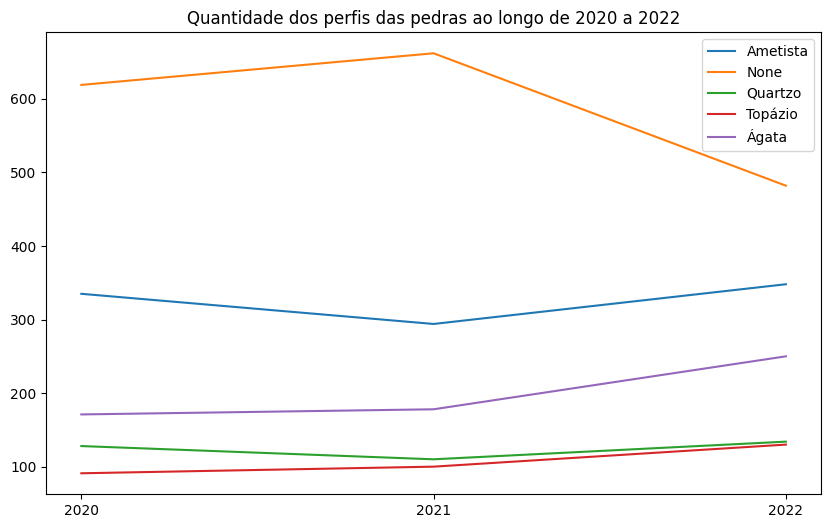

In [ ]:
count_stones_per_year(df)
plot_stone_over_time(df)

In [ ]:

# Assuming 'df' is your DataFrame

# 1. Filter columns containing 'FASE_'
fase_columns = df.filter(regex='NIVEL_IDEAL_2022').columns

# 2. Create a cross-tabulation (contingency table)
fase_instituicao_counts = pd.crosstab(
    df['INSTITUICAO_ENSINO_ALUNO_2022_STR'],  # Rows: Institution
    df[fase_columns].apply(lambda row: ','.join(row.astype(str)), axis=1)  # Columns: Combined FASE values
)

# 3. Display or further process the results
print(fase_instituicao_counts)


col_0                              ,None  ALFA  (2o e 3o ano),ALFA  \
INSTITUICAO_ENSINO_ALUNO_2022_STR                                    
                                     482                         0   
Bolsista Escola Privada                0                         2   
Escola Pública                         0                        69   
Universitário com Bolsa                0                         0   
Universitário sem bolsa                0                         0   

col_0                              Fase 1 (4o ano),1  Fase 2 (5o e 6o ano),2  \
INSTITUICAO_ENSINO_ALUNO_2022_STR                                              
                                                   0                       0   
Bolsista Escola Privada                            3                       8   
Escola Pública                                    93                     210   
Universitário com Bolsa                            0                       0   
Universitário sem bolsa      

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344 entries, 0 to 1345
Data columns (total 84 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   INDEX                              1344 non-null   int64  
 1   NOME_STR                           1344 non-null   object 
 2   INSTITUICAO_ENSINO_ALUNO_2020_STR  1344 non-null   object 
 3   IDADE_ALUNO_2020_INT               1344 non-null   int64  
 4   ANOS_PM_2020_INT                   1344 non-null   float64
 5   SINALIZADOR_INGRESSANTE_2020_STR   1344 non-null   object 
 6   ANO_INGRESSO_2020_DATE             1344 non-null   object 
 7   FASE_TURMA_2020_STR                1344 non-null   object 
 8   FASE_2020_STR                      1344 non-null   object 
 9   TURMA_2020_STR                     1344 non-null   object 
 10  PONTO_VIRADA_2020_STR              1344 non-null   object 
 11  INDE_2020_NUM                      1344 non-null   float64
 1

In [ ]:
df[["NIVEL_IDEAL_2021_STR"]].value_counts()



,count
NIVEL_IDEAL_2021_STR,
,662
Fase 2 (5o e 6o ano),177
Fase 3 (7o e 8o ano),171
Fase 4 (9o ano),73
Fase 1 (4o ano),69
Fase 5 (1o EM),56
ALFA (2o e 3o ano),52
Fase 6 (2o EM),41
Fase 7 (3o EM),36


In [ ]:
df[["INSTITUICAO_ENSINO_ALUNO_2021_STR"]].value_counts()

,count
INSTITUICAO_ENSINO_ALUNO_2021_STR,
,662
Escola Pública,553
Rede Decisão,127
Escola João Paulo II,2


In [ ]:
df[["INSTITUICAO_ENSINO_ALUNO_2022_STR"]].value_counts()

,count
INSTITUICAO_ENSINO_ALUNO_2022_STR,
Escola Pública,733
,482
Bolsista Escola Privada,107
Universitário com Bolsa,12
Universitário sem bolsa,10


In [ ]:
import streamlit as st
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os

st.title("Success Prediction App")

# Data Loading
#data_path = os.path.join(os.path.dirname(__file__), "data", "dataset.csv")
#if os.path.exists(data_path):
#    df = pd.read_csv(data_path)
#    st.write("Data loaded successfully!")

    # ... (rest of your app code)
#else:
#    st.write("Dataset file not found. Please ensure 'dataset.csv' is in the 'data' folder.")
#st.title("Success Prediction App")

# 1. Feature Selection
features = st.multiselect(
    "Select Features (IPV, IPP, IPS, IDA, IAN, IEG, IAA):",
    ["IPV", "IPP", "IPS", "IDA", "IAN", "IEG", "IAA"],
)

# 2. Year Filtering
years = st.multiselect(
    "Select Years (2020, 2021, 2022):",
    [2020, 2021, 2022],
)

# 3. Target Selection
targets = st.multiselect(
    "Select Targets (PONTO_VIRADA_2020, PONTO_VIRADA_2021, PONTO_VIRADA_2022):",
    ["PONTO_VIRADA_2020", "PONTO_VIRADA_2021", "PONTO_VIRADA_2022"],
)

# 4. Model Selection
model_choice = st.selectbox(
    "Select Model:",
    ["Logistic Regression", "Decision Tree", "Random Forest"],
)
# Data Preprocessing (example)
if features and years and targets:
    selected_features = [f"{f}_{y}_NUM" for f in features for y in years]
    X = df[selected_features]
    y = df[targets[0]]  # Assuming you're using only one target for now

    # Model Training and Prediction (example)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    if model_choice == "Logistic Regression":
        model = LogisticRegression()
    elif model_choice == "Decision Tree":
        model = DecisionTreeClassifier()
    elif model_choice == "Random Forest":
        model = RandomForestClassifier()

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Display Results
    st.write("Predictions:", predictions)


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
!streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py